In [ ]:
import numpy as np
from scipy.optimize import minimize
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH para un manipulador 3DOF
# [theta, d, a, alpha]
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares en radianes
joint_limits = [(-np.pi, np.pi), (-np.pi/2, np.pi/2), (-np.pi/2, np.pi/2)]

# Función para ingresar la posición deseada
def input_target_position():
    print("Introduce las coordenadas deseadas para el efector final:")
    x = float(input("Posición en X (m): "))
    y = float(input("Posición en Y (m): "))
    z = float(input("Posición en Z (m): "))
    return np.array([x, y, z])

# Transformación DH
def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

# Cinemática directa
def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    position = T[:3, 3]
    return position, T

# Función objetivo
def position_error(joint_angles, target_position):
    pos, _ = forward_kinematics(joint_angles)
    return np.linalg.norm(pos - target_position)

# Evaluar indicadores de rendimiento
def compute_indicators(opt_result, start_time, target_position):
    joint_angles = opt_result.x
    pos, final_T = forward_kinematics(joint_angles)
    position_err_mm = np.linalg.norm(pos - target_position) * 1000
    compute_time_ms = (time() - start_time) * 1000

    print("\n📊 Indicadores de rendimiento:")
    print(f"- Ángulos articulares (rad): {np.round(joint_angles, 4)}")
    print(f"- Posición alcanzada (m): {np.round(pos, 4)}")
    print(f"- Error de posición: {position_err_mm:.3f} mm")
    print(f"- Tiempo de cómputo: {compute_time_ms:.2f} ms")
    print(f"- Éxito en la optimización: {opt_result.success}")
    print("\n🧩 Matriz de transformación final:")
    print(np.round(final_T, 4))

# Visualización 3D
def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Posición del manipulador 3DOF")
    ax.grid(True)
    plt.show()

# Función principal
def optimize_robot_trajectory():
    target_position = input_target_position()

    # Inicialización
    initial_guess = np.zeros(3)

    start = time()
    result = minimize(position_error, initial_guess, args=(target_position,), method='SLSQP',
                      bounds=joint_limits,
                      options={'disp': True, 'maxiter': 3000, 'ftol': 1e-8})
    compute_indicators(result, start, target_position)

    # Visualización
    plot_robot(result.x)

# Ejecutar
optimize_robot_trajectory()


Introduce las coordenadas deseadas para el efector final:


KeyboardInterrupt: Interrupted by user

In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def input_target_position():
    print("Introduce la posición deseada para el efector final:")
    x = float(input("X (m): "))
    y = float(input("Y (m): "))
    z = float(input("Z (m): "))
    return np.array([x, y, z])

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def optimize_robot_trajectory():
    target = input_target_position()

    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.001)
    initial_guess = np.zeros(3)

    print("\n⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': True, 'maxiter': 3000, 'ftol': 1e-12}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    print("\n✅ Optimización completada")
    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000

        print("\n📊 Indicadores:")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")
        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))

        plot_robot(result.x)
    else:
        print("⚠️ No se encontró una solución válida.")

# Ejecutar
optimize_robot_trajectory()

In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

# Posiciones deseadas a evaluar (modifica aquí tus posiciones)
target_positions = [np.array([0.1, 0.2, 0.3])]

# Área máxima estimada del workspace (de la tabla)
WORKSPACE_RADIUS_MAX = np.sqrt(0.483 / np.pi)

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def is_within_workspace(target):
    """Evalúa si el punto está dentro del radio efectivo máximo"""
    r = np.linalg.norm(target[:2])  # solo XY
    return r <= WORKSPACE_RADIUS_MAX

def optimize_to_position(target):
    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.001)
    initial_guess = np.zeros(3)

    print(f"\n🎯 Posición objetivo: {target}")
    if not is_within_workspace(target):
        print("⚠️ Posición fuera del alcance estimado del robot.\n")
        return

    print("⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': False, 'maxiter': 3000, 'ftol': 1e-12}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000

        print("\n✅ Optimización completada")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")
        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))

        plot_robot(result.x)
    else:
        print("❌ No se encontró una solución válida.\n")

# Ejecutar para todas las posiciones deseadas
for target in target_positions:
    optimize_to_position(target)


🎯 Posición objetivo: [0.1 0.2 0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.



In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def optimize_robot_trajectory(target):
    print(f"\n🎯 Posición objetivo: {target}")

    max_reach = 0.3 + 0.3  # suma de los eslabones
    if np.linalg.norm(target[:2]) > max_reach:
        print("⚠️ Posición fuera del alcance estimado del robot.")
        return

    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.005)  # margen de 5 mm
    initial_guess = np.zeros(3)

    print("⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': True, 'maxiter': 3000, 'ftol': 1e-9}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000
        print("\n✅ Optimización completada")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")
        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))
        plot_robot(result.x)
    else:
        print("❌ No se encontró una solución válida.")

# ✅ Posición objetivo modificable aquí
target_position = np.array([0.2, 0.1, 0.3])
optimize_robot_trajectory(target_position)



🎯 Posición objetivo: [0.2 0.1 0.3]
⏳ Optimizando...
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.20065727096206504
            Iterations: 18
            Function evaluations: 85
            Gradient evaluations: 14
❌ No se encontró una solución válida.



🎯 Posición objetivo: [0.1 0.2 0.3]
⚠️ Posición fuera del alcance estimado del robot.


🎯 Posición objetivo: [0.5 0.  0.3]
⏳ Optimizando...


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



✅ Optimización completada
- Ángulos óptimos (rad): [-0.     -0.5857  1.1714]
- Posición alcanzada (m): [ 0.5 -0.   0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 383.69 ms

🔹 Matriz de transformación final:
[[ 0.8333 -0.5528 -0.      0.5   ]
 [-0.      0.     -1.     -0.    ]
 [ 0.5528  0.8333  0.      0.3   ]
 [ 0.      0.      0.      1.    ]]


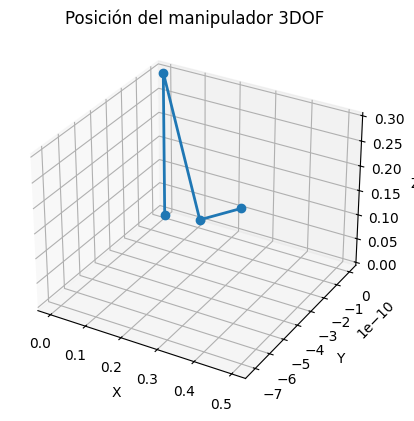


🎯 Posición objetivo: [0.8 0.2 0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.


🎯 Posición objetivo: [0.2 0.  0.3]
⚠️ Posición fuera del alcance estimado del robot.



In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH: [theta, d, a, alpha]
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

# Radios reales del workspace
WORKSPACE_RADIUS_MIN = 0.3  # m
WORKSPACE_RADIUS_MAX = 0.9  # m

# Posiciones deseadas a evaluar (puedes modificar esto)
target_positions = [
    np.array([0.1, 0.2, 0.3]),
    np.array([0.5, 0.0, 0.3]),
    np.array([0.8, 0.2, 0.3]),
    np.array([0.2, 0.0, 0.3])  # este está en el hueco central y debería fallar
]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def is_within_workspace(target):
    """Evalúa si el punto está dentro del anillo de workspace"""
    r = np.linalg.norm(target[:2])  # solo XY
    return WORKSPACE_RADIUS_MIN <= r <= WORKSPACE_RADIUS_MAX

def optimize_to_position(target):
    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.001)
    initial_guess = np.zeros(3)

    print(f"\n🎯 Posición objetivo: {target}")
    if not is_within_workspace(target):
        print("⚠️ Posición fuera del alcance estimado del robot.\n")
        return

    print("⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': False, 'maxiter': 3000, 'ftol': 1e-12}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000

        print("\n✅ Optimización completada")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")
        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))

        plot_robot(result.x)
    else:
        print("❌ No se encontró una solución válida.\n")

# Ejecutar para todas las posiciones deseadas
for target in target_positions:
    optimize_to_position(target)



🎯 Posición objetivo: [0.5 0.  0.3]
⏳ Optimizando...

✅ Optimización completada
- Ángulos óptimos (rad): [-0.     -0.5857  1.1714]
- Posición alcanzada (m): [ 0.5 -0.   0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 153.04 ms

🔹 Matriz de transformación final:
[[ 0.8333 -0.5528 -0.      0.5   ]
 [-0.      0.     -1.     -0.    ]
 [ 0.5528  0.8333  0.      0.3   ]
 [ 0.      0.      0.      1.    ]]


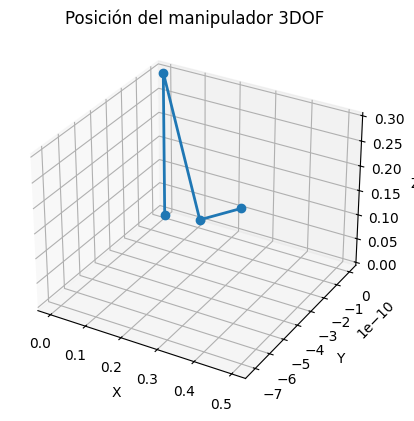


🎯 Posición objetivo: [0.3 0.3 0.3]
⏳ Optimizando...

✅ Optimización completada
- Ángulos óptimos (rad): [ 0.7854 -0.7854  1.5708]
- Posición alcanzada (m): [0.3 0.3 0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 61.33 ms

🔹 Matriz de transformación final:
[[ 0.5    -0.5     0.7071  0.3   ]
 [ 0.5    -0.5    -0.7071  0.3   ]
 [ 0.7071  0.7071  0.      0.3   ]
 [ 0.      0.      0.      1.    ]]


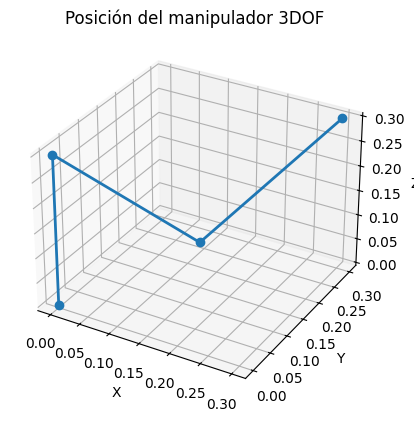


🎯 Posición objetivo: [-0.5  0.2  0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.


🎯 Posición objetivo: [ 0.  -0.6  0.3]
⏳ Optimizando...

✅ Optimización completada
- Ángulos óptimos (rad): [-1.5708 -0.      0.    ]
- Posición alcanzada (m): [ 0.  -0.6  0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 7.02 ms

🔹 Matriz de transformación final:
[[ 0.   0.  -1.   0. ]
 [-1.   0.  -0.  -0.6]
 [ 0.   1.   0.   0.3]
 [ 0.   0.   0.   1. ]]


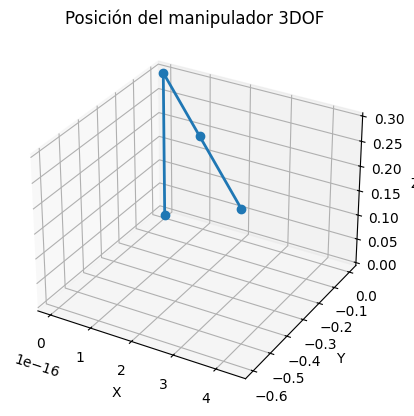


🎯 Posición objetivo: [0.7 0.1 0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.


🎯 Posición objetivo: [-0.3 -0.3  0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.



In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH: [theta, d, a, alpha]
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

# Radios reales del workspace
WORKSPACE_RADIUS_MIN = 0.3  # m
WORKSPACE_RADIUS_MAX = 0.9  # m

# Posiciones deseadas a evaluar (puedes modificar esto)
target_positions = [
    np.array([0.5, 0.0, 0.3]),    # en el eje X
    np.array([0.3, 0.3, 0.3]),    # en diagonal 45°
    np.array([-0.5, 0.2, 0.3]),   # en cuadrante opuesto
    np.array([0.0, -0.6, 0.3]),   # eje Y negativo
    np.array([0.7, 0.1, 0.3]),    # cerca del radio máximo
    np.array([-0.3, -0.3, 0.3])   # dentro del workspace pero en cuadrante negativo
]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def is_within_workspace(target):
    """Evalúa si el punto está dentro del anillo de workspace"""
    r = np.linalg.norm(target[:2])  # solo XY
    return WORKSPACE_RADIUS_MIN <= r <= WORKSPACE_RADIUS_MAX

def optimize_to_position(target):
    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.001)
    initial_guess = np.zeros(3)

    print(f"\n🎯 Posición objetivo: {target}")
    if not is_within_workspace(target):
        print("⚠️ Posición fuera del alcance estimado del robot.\n")
        return

    print("⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': False, 'maxiter': 3000, 'ftol': 1e-12}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000

        print("\n✅ Optimización completada")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")
        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))

        plot_robot(result.x)
    else:
        print("❌ No se encontró una solución válida.\n")

# Ejecutar para todas las posiciones deseadas
for target in target_positions:
    optimize_to_position(target)



🎯 Posición objetivo: [0.5 0.  0.3]
⏳ Optimizando...


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



✅ Optimización completada
- Ángulos óptimos (rad): [-0.     -0.5857  1.1714]
- Posición alcanzada (m): [ 0.5 -0.   0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 648.47 ms
🟢 Precisión ALTA (<1mm)

🔹 Matriz de transformación final:
[[ 0.8333 -0.5528 -0.      0.5   ]
 [-0.      0.     -1.     -0.    ]
 [ 0.5528  0.8333  0.      0.3   ]
 [ 0.      0.      0.      1.    ]]


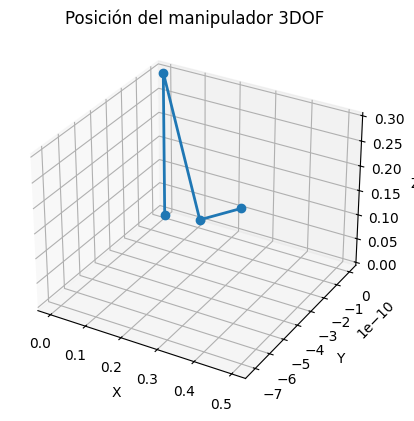


🎯 Posición objetivo: [0.3 0.3 0.3]
⏳ Optimizando...

✅ Optimización completada
- Ángulos óptimos (rad): [ 0.7854 -0.7854  1.5708]
- Posición alcanzada (m): [0.3 0.3 0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 152.50 ms
🟢 Precisión ALTA (<1mm)

🔹 Matriz de transformación final:
[[ 0.5    -0.5     0.7071  0.3   ]
 [ 0.5    -0.5    -0.7071  0.3   ]
 [ 0.7071  0.7071  0.      0.3   ]
 [ 0.      0.      0.      1.    ]]


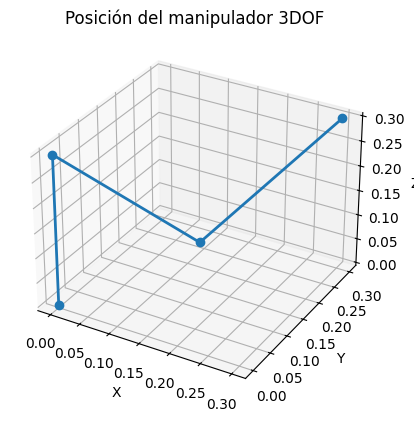


🎯 Posición objetivo: [-0.5  0.2  0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.


🎯 Posición objetivo: [ 0.  -0.6  0.3]
⏳ Optimizando...

✅ Optimización completada
- Ángulos óptimos (rad): [-1.5708 -0.      0.    ]
- Posición alcanzada (m): [ 0.  -0.6  0.3]
- Error de posición: 0.000 mm
- Tiempo de cómputo: 46.54 ms
🟢 Precisión ALTA (<1mm)

🔹 Matriz de transformación final:
[[ 0.   0.  -1.   0. ]
 [-1.   0.  -0.  -0.6]
 [ 0.   1.   0.   0.3]
 [ 0.   0.   0.   1. ]]


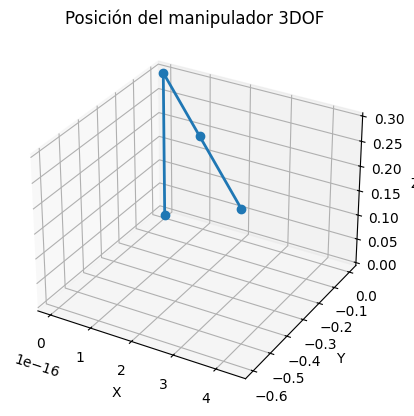


🎯 Posición objetivo: [0.7 0.1 0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.


🎯 Posición objetivo: [-0.3 -0.3  0.3]
⏳ Optimizando...
❌ No se encontró una solución válida.



In [ ]:
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH
DH_params = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  0]
]

# Límites articulares
joint_limits = [(-np.pi/2, np.pi/2), (-np.pi, np.pi), (-np.pi/2, np.pi/2)]

# Posiciones deseadas dentro del workspace anular
target_positions = [
    np.array([0.5, 0.0, 0.3]),
    np.array([0.3, 0.3, 0.3]),
    np.array([-0.5, 0.2, 0.3]),
    np.array([0.0, -0.6, 0.3]),
    np.array([0.7, 0.1, 0.3]),
    np.array([-0.3, -0.3, 0.3])
]

# Radio máximo aproximado del workspace en el plano XY
WORKSPACE_RADIUS_MAX = 0.9
WORKSPACE_RADIUS_MIN = 0.3

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(3):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Posición del manipulador 3DOF")
    plt.show()

def is_within_workspace(target):
    r = np.linalg.norm(target[:2])  # solo XY
    return WORKSPACE_RADIUS_MIN <= r <= WORKSPACE_RADIUS_MAX

def optimize_to_position(target):
    def position_error(joint_angles):
        pos, _ = forward_kinematics(joint_angles)
        return np.linalg.norm(pos - target)

    constraint = NonlinearConstraint(position_error, 0.0, 0.001)
    initial_guess = np.zeros(3)

    print(f"\n🎯 Posición objetivo: {target}")
    if not is_within_workspace(target):
        print("⚠️ Posición fuera del alcance estimado del robot.\n")
        return

    print("⏳ Optimizando...")
    start_time = time()
    result = minimize(
        position_error,
        initial_guess,
        method='SLSQP',
        bounds=joint_limits,
        constraints=[constraint],
        options={'disp': False, 'maxiter': 3000, 'ftol': 1e-12}
    )
    elapsed_time_ms = (time() - start_time) * 1000

    if result.success:
        final_pos, final_T = forward_kinematics(result.x)
        error_mm = np.linalg.norm(final_pos - target) * 1000

        print("\n✅ Optimización completada")
        print(f"- Ángulos óptimos (rad): {np.round(result.x, 4)}")
        print(f"- Posición alcanzada (m): {np.round(final_pos, 4)}")
        print(f"- Error de posición: {error_mm:.3f} mm")
        print(f"- Tiempo de cómputo: {elapsed_time_ms:.2f} ms")

        if error_mm < 1:
            print("🟢 Precisión ALTA (<1mm)")
        elif error_mm < 10:
            print("🟡 Precisión MODERADA (<10mm)")
        else:
            print("🔴 Baja precisión (>10mm)")

        print("\n🔹 Matriz de transformación final:")
        print(np.round(final_T, 4))
        plot_robot(result.x)

    else:
        print("❌ No se encontró una solución válida.\n")

# Ejecutar para todas las posiciones deseadas
for target in target_positions:
    optimize_to_position(target)



🎯 Objetivo: [0.5 0.  0.5]
✅ Solución encontrada
Ángulos (rad): [ 0.7026  2.1395 -1.5739 -0.2656 -0.7162  1.4031 -1.2588]
Posición alcanzada: [4.999e-01 1.000e-04 5.000e-01]
Error de posición: 0.13 mm


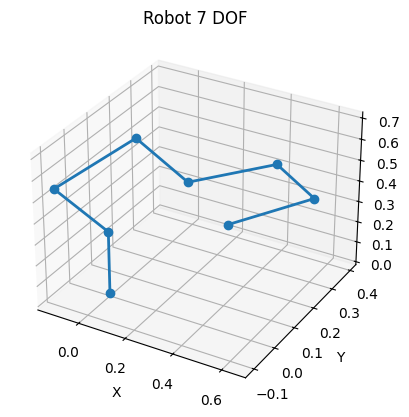


🎯 Objetivo: [0.3 0.4 0.6]
✅ Solución encontrada
Ángulos (rad): [-2.1553  1.1616 -2.5673 -1.619  -1.4088 -2.3326  0.8496]
Posición alcanzada: [0.3    0.3999 0.6   ]
Error de posición: 0.07 mm


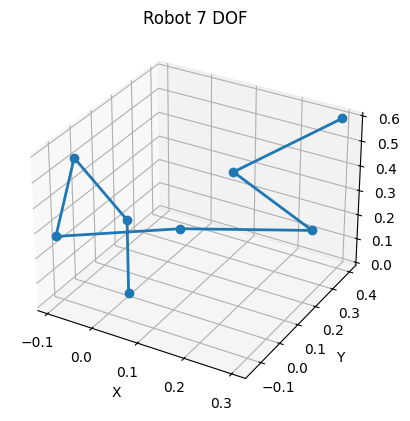


🎯 Objetivo: [-0.4  0.4  0.3]
✅ Solución encontrada
Ángulos (rad): [ 2.6776  1.0194 -0.7324  2.7534  2.5375  2.7483  0.9209]
Posición alcanzada: [-0.3995  0.3998  0.3001]
Error de posición: 0.54 mm


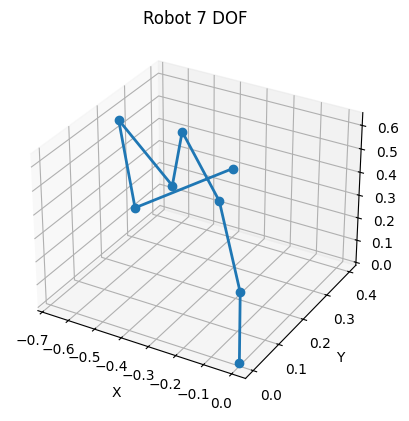


🎯 Objetivo: [ 0.  -0.8  0.4]
✅ Solución encontrada
Ángulos (rad): [-0.7203  0.7595  0.4209  1.5138 -0.0467  0.0488 -0.3287]
Posición alcanzada: [-0.  -0.8  0.4]
Error de posición: 0.01 mm


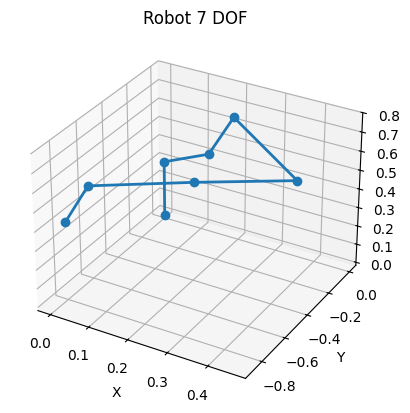

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parámetros DH para un robot de 7 DOF (puedes ajustar según tu robot real)
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Límite de trabajo
WORKSPACE_RADIUS_MAX = 1.5
WORKSPACE_RADIUS_MIN = 0.3

# Límites articulares
joint_limits = [(-np.pi, np.pi)] * 7

# Posiciones objetivo
target_positions = [
    np.array([0.5, 0.0, 0.5]),
    np.array([0.3, 0.4, 0.6]),
    np.array([-0.4, 0.4, 0.3]),
    np.array([0.0, -0.8, 0.4])
]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def compute_jacobian(joint_angles, delta=1e-6):
    J = np.zeros((3, 7))
    f0, _ = forward_kinematics(joint_angles)
    for i in range(7):
        dq = np.copy(joint_angles)
        dq[i] += delta
        f1, _ = forward_kinematics(dq)
        J[:, i] = (f1 - f0) / delta
    return J

def damped_pseudoinverse(J, damping=1e-2):
    m, n = J.shape
    return J.T @ np.linalg.inv(J @ J.T + damping**2 * np.eye(m))

def is_within_workspace(target):
    r = np.linalg.norm(target[:2])
    return WORKSPACE_RADIUS_MIN <= r <= WORKSPACE_RADIUS_MAX

def inverse_kinematics(target_pos, initial_guess=None, max_iter=1500, tol=1e-3):
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/2, np.pi/2, 7)

    for i in range(max_iter):
        current_pos, _ = forward_kinematics(joint_angles)
        error = target_pos - current_pos
        if np.linalg.norm(error) < tol:
            return joint_angles

        J = compute_jacobian(joint_angles)
        J_pinv = damped_pseudoinverse(J)
        joint_angles += J_pinv @ error

        # Limitar ángulos a sus rangos
        for j in range(7):
            joint_angles[j] = np.clip(joint_angles[j], joint_limits[j][0], joint_limits[j][1])

    return None  # No convergió

def plot_robot(joint_angles):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Robot 7 DOF")
    plt.show()

# Ejecutar cinemática inversa para cada objetivo
for target in target_positions:
    print(f"\n🎯 Objetivo: {target}")
    result = inverse_kinematics(target)
    if result is not None:
        final_pos, _ = forward_kinematics(result)
        error = np.linalg.norm(final_pos - target) * 1000
        print("✅ Solución encontrada")
        print(f"Ángulos (rad): {np.round(result, 4)}")
        print(f"Posición alcanzada: {np.round(final_pos, 4)}")
        print(f"Error de posición: {error:.2f} mm")
        plot_robot(result)
    else:
        print("❌ No se encontró solución\n")


**1. Código del profe con jacobiano**


🎯 Objetivo: [-1.   0.3  1.2]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 2.0703 segundos


🎯 Objetivo: [ 0.2 -0.9  0.5]
✅ Solución encontrada
Ángulos (rad): [-1.8269  1.5224 -1.2656  1.7329  3.1416 -1.894  -1.48  ]
Posición alcanzada: [ 0.2001 -0.8998  0.5009]
Error de posición: 0.97 mm
⏱️ Tiempo de cómputo: 0.0206 segundos


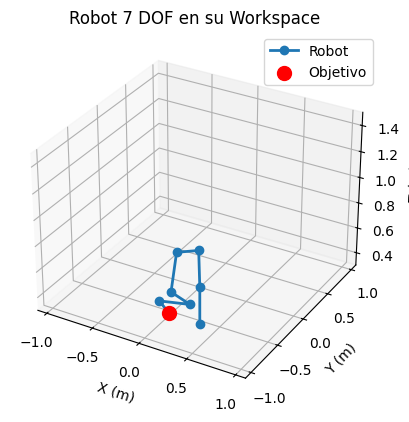


🎯 Objetivo: [1.1 1.1 0.3]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 3.3370 segundos


🎯 Objetivo: [0.  0.  1.5]
✅ Solución encontrada
Ángulos (rad): [-1.4012  0.6286  1.4377  0.18    0.0384 -1.0923  0.677 ]
Posición alcanzada: [1.0000e-04 1.0000e-04 1.4996e+00]
Error de posición: 0.45 mm
⏱️ Tiempo de cómputo: 0.0044 segundos


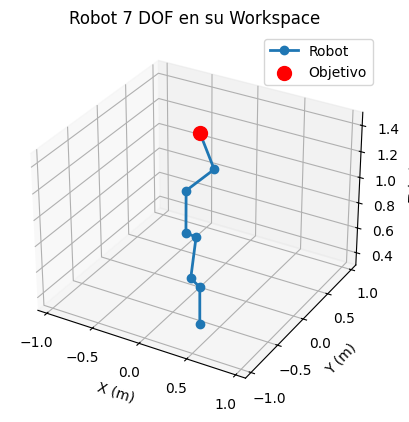

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Parámetros DH del robot 7DOF
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Límites articulares
joint_limits = [(-np.pi, np.pi)] * 7

# Límite del espacio de trabajo del artículo (en metros)
WORKSPACE_X = (-1.1, 1.1)
WORKSPACE_Y = (-1.1, 1.1)
WORKSPACE_Z = (0.3, 1.5)

# Puntos deseados dentro del workspace cúbico
target_positions = [
    np.array([-1.0, 0.3, 1.2]),
    np.array([0.2, -0.9, 0.5]),
    np.array([1.1, 1.1, 0.3]),
    np.array([0.0, 0.0, 1.5])
]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def compute_jacobian(joint_angles, delta=1e-6):
    J = np.zeros((3, 7))
    f0, _ = forward_kinematics(joint_angles)
    for i in range(7):
        dq = np.copy(joint_angles)
        dq[i] += delta
        f1, _ = forward_kinematics(dq)
        J[:, i] = (f1 - f0) / delta
    return J

def damped_pseudoinverse(J, damping=1e-2):
    m, n = J.shape
    return J.T @ np.linalg.inv(J @ J.T + damping**2 * np.eye(m))

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def inverse_kinematics(target_pos, initial_guess=None, max_iter=1500, tol=1e-3):
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

## Preguntar si se puede establecer una posicion inicial

    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/2, np.pi/2, 7)

    for i in range(max_iter):
        current_pos, _ = forward_kinematics(joint_angles)
        error = target_pos - current_pos
        if np.linalg.norm(error) < tol:
            return joint_angles

        J = compute_jacobian(joint_angles)
        J_pinv = damped_pseudoinverse(J)
        joint_angles += J_pinv @ error

        # Limitar ángulos a sus rangos
        for j in range(7):
            joint_angles[j] = np.clip(joint_angles[j], joint_limits[j][0], joint_limits[j][1])

    return None

def plot_robot(joint_angles, target=None):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2, label="Robot")
    if target is not None:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Robot 7 DOF en su Workspace")
    ax.legend()
    plt.show()

# Ejecutar cinemática inversa para cada objetivo
for target in target_positions:
    print(f"\n🎯 Objetivo: {target}")

    start_time = time.time()  # ⏱️ inicio del cronómetro

    result = inverse_kinematics(target)

    end_time = time.time()    # ⏱️ fin del cronómetro
    elapsed_time = end_time - start_time

    if result is not None:
        final_pos, _ = forward_kinematics(result)
        error = np.linalg.norm(final_pos - target) * 1000
        print("✅ Solución encontrada")
        print(f"Ángulos (rad): {np.round(result, 4)}")
        print(f"Posición alcanzada: {np.round(final_pos, 4)}")
        print(f"Error de posición: {error:.2f} mm")
        print(f"⏱️ Tiempo de cómputo: {elapsed_time:.4f} segundos")
        plot_robot(result, target)
    else:
        print("❌ No se encontró solución")
        print(f"⏱️ Tiempo de cómputo: {elapsed_time:.4f} segundos\n")

**1.2. Codigo del profe con jacobiano y con diferentes grados de libertad**


🦾 [Jacobiano] Robot 2 DOF | Objetivo: [0.12 0.12 0.55]
✅ Solución encontrada
📍 Posición alcanzada: [0.119 0.119 0.548]
🌀 Ángulos articulares (rad): [0.7854 0.9744]
🌀 Ángulos articulares (°): [45.   55.83]
📏 Error de posición: 2.16 mm
🔄 Error de rotación: 70.55° (❌ >1°)
⏱️ Tiempo de cómputo: 0.4869 s


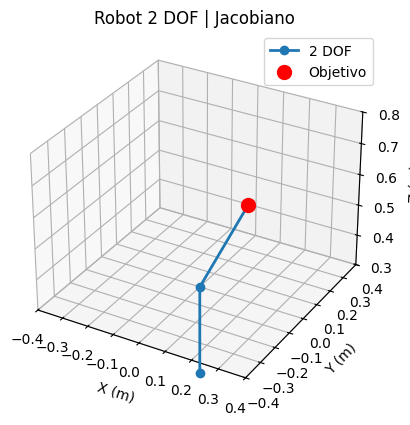


🦾 [Jacobiano] Robot 2 DOF | Objetivo: [0.8 0.8 1.2]
⚠️ Objetivo fuera del espacio de trabajo (2 DOF): [0.8 0.8 1.2]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [Jacobiano] Robot 3 DOF | Objetivo: [0.15 0.15 0.65]
✅ Solución encontrada
📍 Posición alcanzada: [0.155 0.155 0.663]
🌀 Ángulos articulares (rad): [0.7854 0.2405 0.593 ]
🌀 Ángulos articulares (°): [45.   13.78 33.98]
📏 Error de posición: 15.00 mm
🔄 Error de rotación: 115.50° (❌ >1°)
⏱️ Tiempo de cómputo: 0.7479 s


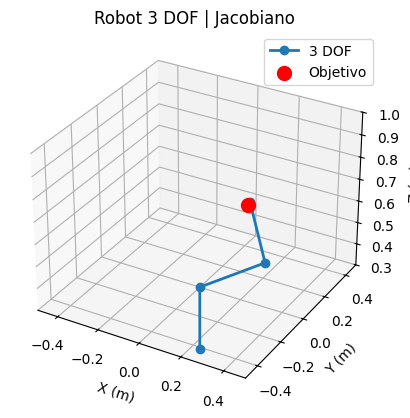


🦾 [Jacobiano] Robot 3 DOF | Objetivo: [0.9 0.9 1.4]
⚠️ Objetivo fuera del espacio de trabajo (3 DOF): [0.9 0.9 1.4]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0003 s

🦾 [Jacobiano] Robot 4 DOF | Objetivo: [0.18 0.18 0.7 ]
✅ Solución encontrada
📍 Posición alcanzada: [0.18 0.18 0.7 ]
🌀 Ángulos articulares (rad): [ 1.2123  0.8996 -0.5903 -0.888 ]
🌀 Ángulos articulares (°): [ 69.46  51.54 -33.82 -50.88]
📏 Error de posición: 0.11 mm
🔄 Error de rotación: 54.23° (❌ >1°)
⏱️ Tiempo de cómputo: 0.0060 s


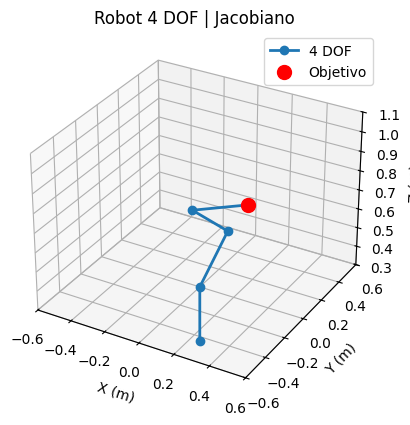


🦾 [Jacobiano] Robot 4 DOF | Objetivo: [1.  1.  1.5]
⚠️ Objetivo fuera del espacio de trabajo (4 DOF): [1.  1.  1.5]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [Jacobiano] Robot 5 DOF | Objetivo: [0.42 0.42 0.72]
✅ Solución encontrada
📍 Posición alcanzada: [0.456 0.376 0.72 ]
🌀 Ángulos articulares (rad): [ 3.1416  1.6118  1.9229  2.0241 -0.2442]
🌀 Ángulos articulares (°): [180.    92.35 110.17 115.97 -13.99]
📏 Error de posición: 56.41 mm
🔄 Error de rotación: 36.24° (❌ >1°)
⏱️ Tiempo de cómputo: 1.5344 s


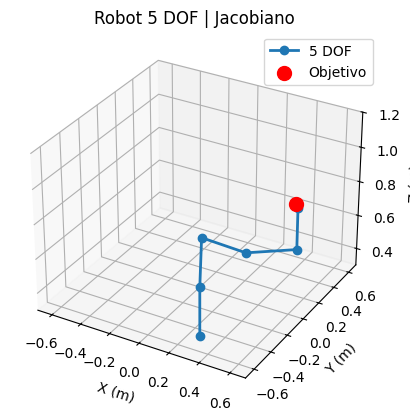


🦾 [Jacobiano] Robot 5 DOF | Objetivo: [1.1 1.1 1.6]
⚠️ Objetivo fuera del espacio de trabajo (5 DOF): [1.1 1.1 1.6]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0003 s

🦾 [Jacobiano] Robot 6 DOF | Objetivo: [0.48 0.48 0.78]
✅ Solución encontrada
📍 Posición alcanzada: [0.479 0.48  0.779]
🌀 Ángulos articulares (rad): [ 1.5127  0.613  -1.2253 -0.877  -2.3428 -3.1416]
🌀 Ángulos articulares (°): [  86.67   35.12  -70.21  -50.25 -134.23 -180.  ]
📏 Error de posición: 0.95 mm
🔄 Error de rotación: 141.75° (❌ >1°)
⏱️ Tiempo de cómputo: 0.0292 s


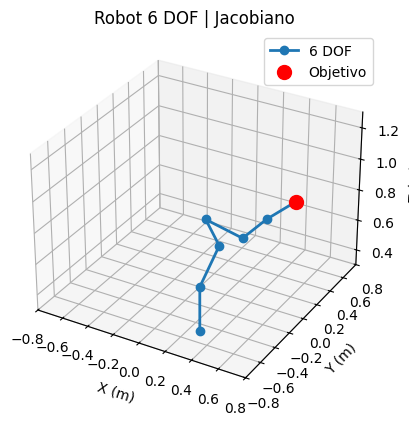


🦾 [Jacobiano] Robot 6 DOF | Objetivo: [1.2 1.2 1.7]
⚠️ Objetivo fuera del espacio de trabajo (6 DOF): [1.2 1.2 1.7]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [Jacobiano] Robot 7 DOF | Objetivo: [0.6 0.6 0.9]
✅ Solución encontrada
📍 Posición alcanzada: [0.6 0.6 0.9]
🌀 Ángulos articulares (rad): [ 0.4789 -0.1301  0.8967  0.6022 -0.5062 -1.3692 -0.3587]
🌀 Ángulos articulares (°): [ 27.44  -7.45  51.37  34.5  -29.   -78.45 -20.55]
📏 Error de posición: 0.04 mm
🔄 Error de rotación: 93.28° (❌ >1°)
⏱️ Tiempo de cómputo: 0.0104 s


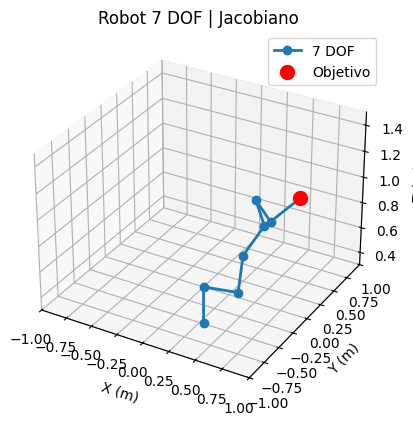


🦾 [Jacobiano] Robot 7 DOF | Objetivo: [1.4 1.4 1.9]
⚠️ Objetivo fuera del espacio de trabajo (7 DOF): [1.4 1.4 1.9]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

WORKSPACES = {
    2: (-0.4, 0.4, -0.4, 0.4, 0.3, 0.8),
    3: (-0.5, 0.5, -0.5, 0.5, 0.3, 1.0),
    4: (-0.6, 0.6, -0.6, 0.6, 0.3, 1.1),
    5: (-0.7, 0.7, -0.7, 0.7, 0.3, 1.2),
    6: (-0.8, 0.8, -0.8, 0.8, 0.3, 1.3),
    7: (-1.0, 1.0, -1.0, 1.0, 0.3, 1.5)
}

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles, dh_params):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(len(joint_angles)):
        theta = joint_angles[i] + dh_params[i][0]
        d, a, alpha = dh_params[i][1], dh_params[i][2], dh_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    return T[:3, 3], T[:3, :3], T, xs, ys, zs

def compute_jacobian(joint_angles, dh_params, delta=1e-6):
    J = np.zeros((3, len(joint_angles)))
    f0, _, _, _, _, _ = forward_kinematics(joint_angles, dh_params)
    for i in range(len(joint_angles)):
        dq = np.copy(joint_angles)
        dq[i] += delta
        f1, _, _, _, _, _ = forward_kinematics(dq, dh_params)
        J[:, i] = (f1 - f0) / delta
    return J

def damped_pseudoinverse(J, damping=1e-2):
    m, n = J.shape
    return J.T @ np.linalg.inv(J @ J.T + damping**2 * np.eye(m))

def rotation_error_deg(R1, R2):
    R_diff = R1 @ R2.T
    angle_rad = np.arccos(np.clip((np.trace(R_diff) - 1) / 2, -1.0, 1.0))
    return np.degrees(angle_rad)

def is_within_workspace(pos, dof):
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    x, y, z = pos
    return (x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max)

def inverse_kinematics(target_pos, dh_params, dof, initial_guess=None, max_iter=1500, tol=1e-3):
    if not is_within_workspace(target_pos, dof):
        print(f"⚠️ Objetivo fuera del espacio de trabajo ({dof} DOF): {np.round(target_pos, 3)}")
        return None

    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/4, np.pi/4, dof)
    for _ in range(max_iter):
        current_pos, _, _, _, _, _ = forward_kinematics(joint_angles, dh_params)
        error = target_pos - current_pos
        if np.linalg.norm(error) < tol:
            return joint_angles
        J = compute_jacobian(joint_angles, dh_params)
        J_pinv = damped_pseudoinverse(J)
        joint_angles += J_pinv @ error
        joint_angles = np.clip(joint_angles, -np.pi, np.pi)
    return joint_angles

def plot_robot(xs, ys, zs, target, dof, rot_error_deg):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', label=f"{dof} DOF", linewidth=2)
    ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"Robot {dof} DOF | Jacobiano")
    ax.legend()
    plt.show()

def generate_target_points(dof):
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    if dof <= 4:
        inside = np.array([
            0.3 * x_max,
            0.3 * y_max,
            0.5 * (z_min + z_max)
        ])
    else:
        inside = np.array([
            0.6 * x_max,
            0.6 * y_max,
            0.6 * z_max
        ])
    outside = np.array([
        x_max + 0.4,
        y_max + 0.4,
        z_max + 0.4
    ])
    return inside, outside

def run_evaluation(dof):
    dh_params = [[0, 0.3 if i % 2 == 0 else 0.0, 0.3 if i % 2 == 1 else 0.0, np.pi/2 * (-1)**i] for i in range(dof)]
    target_inside, target_outside = generate_target_points(dof)

    for target in [target_inside, target_outside]:
        print(f"\n🦾 [Jacobiano] Robot {dof} DOF | Objetivo: {np.round(target, 3)}")
        start_time = time.time()
        result = inverse_kinematics(target, dh_params, dof)
        elapsed = time.time() - start_time

        if result is not None:
            final_pos, final_rot, _, xs, ys, zs = forward_kinematics(result, dh_params)
            pos_error = np.linalg.norm(target - final_pos)
            rot_error_deg = rotation_error_deg(final_rot, np.eye(3))

            print("✅ Solución encontrada")
            print(f"📍 Posición alcanzada: {np.round(final_pos, 3)}")
            print(f"🌀 Ángulos articulares (rad): {np.round(result, 4)}")
            print(f"🌀 Ángulos articulares (°): {np.round(np.degrees(result), 2)}")
            print(f"📏 Error de posición: {pos_error*1000:.2f} mm")
            print(f"🔄 Error de rotación: {rot_error_deg:.2f}° {'(✔️ OK)' if rot_error_deg <= 1.0 else '(❌ >1°)'}")
            print(f"⏱️ Tiempo de cómputo: {elapsed:.4f} s")
            plot_robot(xs, ys, zs, target, dof, rot_error_deg)
        else:
            print("❌ No se encontró solución")
            print(f"⏱️ Tiempo de cómputo: {elapsed:.4f} s")

# Ejecutar para DOF de 2 a 7
for dof in range(2, 8):
    run_evaluation(dof)

**2. CÓDIGO PROFE CON MÉTODO SLSQP**




🎯 Objetivo: [-1.   0.3  1.2]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0279 segundos


🎯 Objetivo: [ 0.2 -0.9  0.5]
✅ Solución encontrada
Ángulos (rad): [-1.3037  0.5977 -0.9941 -1.5376  1.629   0.0344  1.2088]
Posición alcanzada: [ 0.2001 -0.9001  0.4999]
Error de posición: 0.16 mm
⏱️ Tiempo de cómputo: 0.0332 segundos


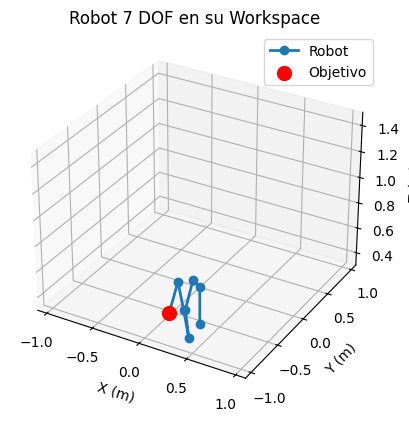


🎯 Objetivo: [1.1 1.1 0.3]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0482 segundos


🎯 Objetivo: [0.  0.  1.5]
✅ Solución encontrada
Ángulos (rad): [ 0.0893  2.0268  0.93   -1.3127 -1.6738 -1.4162  0.8053]
Posición alcanzada: [-1.0000e-04 -0.0000e+00  1.5001e+00]
Error de posición: 0.18 mm
⏱️ Tiempo de cómputo: 0.0303 segundos


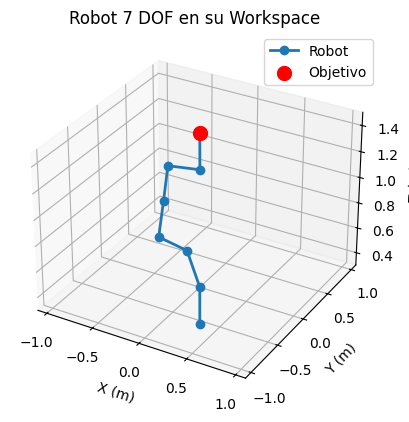

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

# Parámetros DH del robot 7DOF
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Límites articulares
joint_limits = [(-np.pi, np.pi)] * 7

# Workspace
WORKSPACE_X = (-1.1, 1.1)
WORKSPACE_Y = (-1.1, 1.1)
WORKSPACE_Z = (0.3, 1.5)

# Objetivos
target_positions = [
    np.array([-1.0, 0.3, 1.2]),
    np.array([0.2, -0.9, 0.5]),
    np.array([1.1, 1.1, 0.3]),
    np.array([0.0, 0.0, 1.5])
]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def objective_function(joint_angles, target_pos):
    current_pos, _ = forward_kinematics(joint_angles)
    return np.linalg.norm(target_pos - current_pos)

def inverse_kinematics_slsqp(target_pos, initial_guess=None):
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

    if initial_guess is None:
        initial_guess = np.random.uniform(-np.pi/2, np.pi/2, 7)

    bounds = joint_limits

    result = minimize(
        objective_function,
        initial_guess,
        args=(target_pos,),
        method='SLSQP',
        bounds=bounds,
        options={'ftol': 1e-4, 'disp': False, 'maxiter': 1000}
    )

    if result.success and objective_function(result.x, target_pos) < 1e-3:
        return result.x
    else:
        return None

def plot_robot(joint_angles, target=None):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2, label="Robot")
    if target is not None:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Robot 7 DOF en su Workspace")
    ax.legend()
    plt.show()

# Ejecutar cinemática inversa con SLSQP
for target in target_positions:
    print(f"\n🎯 Objetivo: {target}")
    start_time = time.time()

    result = inverse_kinematics_slsqp(target)

    end_time = time.time()
    elapsed_time = end_time - start_time

    if result is not None:
        final_pos, _ = forward_kinematics(result)
        error = np.linalg.norm(final_pos - target) * 1000
        print("✅ Solución encontrada")
        print(f"Ángulos (rad): {np.round(result, 4)}")
        print(f"Posición alcanzada: {np.round(final_pos, 4)}")
        print(f"Error de posición: {error:.2f} mm")
        print(f"⏱️ Tiempo de cómputo: {elapsed_time:.4f} segundos")
        plot_robot(result, target)
    else:
        print("❌ No se encontró solución")
        print(f"⏱️ Tiempo de cómputo: {elapsed_time:.4f} segundos\n")


**2.1 CÓDIGO PROFE CON MÉTODO SLSQP CON TODOS LOS DOF**


🦾 [SLSPQ] Robot 2 DOF | Objetivo: [0.12 0.12 0.55]
✅ Solución encontrada
📍 Posición alcanzada: [0.119 0.119 0.548]
🌀 Ángulos articulares (°): [45.   55.83]
📏 Error posición: 2.16 mm
🔄 Error rotación: 70.55° (❌)
⏱️ Tiempo de cómputo: 0.4650 s


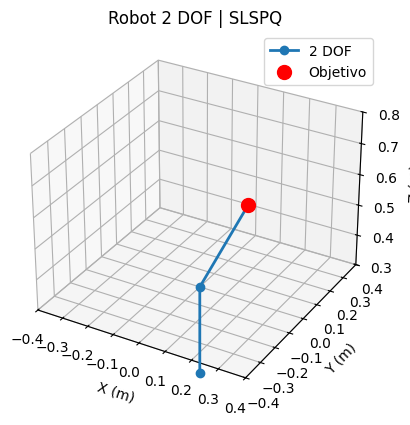


🦾 [SLSPQ] Robot 2 DOF | Objetivo: [0.8 0.8 1.2]
⚠️ Objetivo fuera del espacio de trabajo (2 DOF): [0.8 0.8 1.2]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [SLSPQ] Robot 3 DOF | Objetivo: [0.15 0.15 0.65]
✅ Solución encontrada
📍 Posición alcanzada: [0.155 0.155 0.663]
🌀 Ángulos articulares (°): [45.   13.78 11.25]
📏 Error posición: 15.00 mm
🔄 Error rotación: 107.05° (❌)
⏱️ Tiempo de cómputo: 0.9971 s


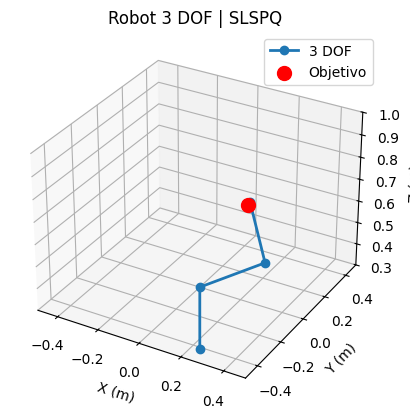


🦾 [SLSPQ] Robot 3 DOF | Objetivo: [0.9 0.9 1.4]
⚠️ Objetivo fuera del espacio de trabajo (3 DOF): [0.9 0.9 1.4]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0003 s

🦾 [SLSPQ] Robot 4 DOF | Objetivo: [0.18 0.18 0.7 ]
✅ Solución encontrada
📍 Posición alcanzada: [0.18 0.18 0.7 ]
🌀 Ángulos articulares (°): [ 44.34  51.04   0.98 -55.23]
📏 Error posición: 0.01 mm
🔄 Error rotación: 45.12° (❌)
⏱️ Tiempo de cómputo: 0.0091 s


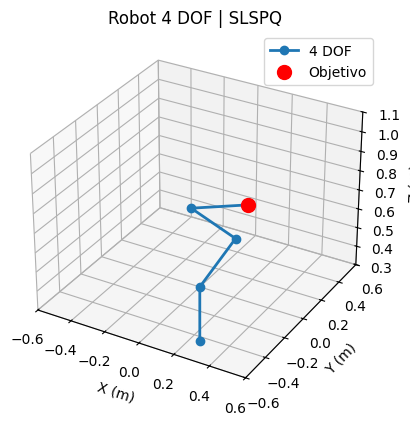


🦾 [SLSPQ] Robot 4 DOF | Objetivo: [1.  1.  1.5]
⚠️ Objetivo fuera del espacio de trabajo (4 DOF): [1.  1.  1.5]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [SLSPQ] Robot 5 DOF | Objetivo: [0.42 0.42 0.72]
✅ Solución encontrada
📍 Posición alcanzada: [0.424 0.424 0.3  ]
🌀 Ángulos articulares (°): [-135.   -180.   -180.    180.     24.74]
📏 Error posición: 420.04 mm
🔄 Error rotación: 109.08° (❌)
⏱️ Tiempo de cómputo: 1.5483 s


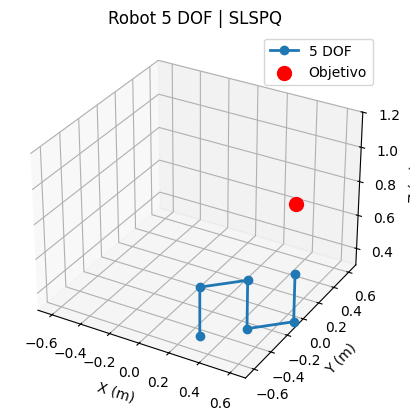


🦾 [SLSPQ] Robot 5 DOF | Objetivo: [1.1 1.1 1.6]
⚠️ Objetivo fuera del espacio de trabajo (5 DOF): [1.1 1.1 1.6]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [SLSPQ] Robot 6 DOF | Objetivo: [0.48 0.48 0.78]
✅ Solución encontrada
📍 Posición alcanzada: [0.533 0.533 0.564]
🌀 Ángulos articulares (°): [-135.   -180.     -0.    -96.15   -0.     45.  ]
📏 Error posición: 228.80 mm
🔄 Error rotación: 160.98° (❌)
⏱️ Tiempo de cómputo: 2.0122 s


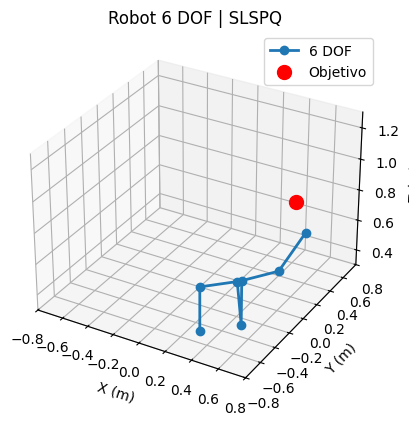


🦾 [SLSPQ] Robot 6 DOF | Objetivo: [1.2 1.2 1.7]
⚠️ Objetivo fuera del espacio de trabajo (6 DOF): [1.2 1.2 1.7]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s

🦾 [SLSPQ] Robot 7 DOF | Objetivo: [0.6 0.6 0.9]
✅ Solución encontrada
📍 Posición alcanzada: [0.531 0.531 0.881]
🌀 Ángulos articulares (°): [-135.    123.83 -180.   -180.    180.   -180.     45.  ]
📏 Error posición: 100.13 mm
🔄 Error rotación: 61.54° (❌)
⏱️ Tiempo de cómputo: 2.6571 s


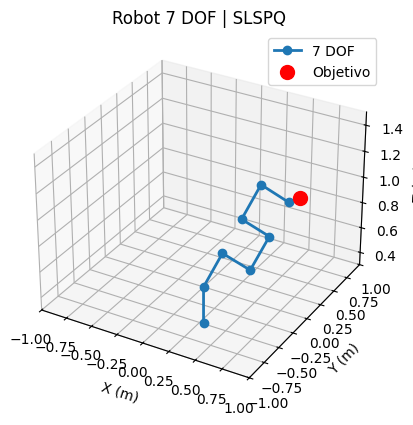


🦾 [SLSPQ] Robot 7 DOF | Objetivo: [1.4 1.4 1.9]
⚠️ Objetivo fuera del espacio de trabajo (7 DOF): [1.4 1.4 1.9]
❌ No se encontró solución
⏱️ Tiempo de cómputo: 0.0002 s


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Espacios de trabajo por DOF
WORKSPACES = {
    2: (-0.4, 0.4, -0.4, 0.4, 0.3, 0.8),
    3: (-0.5, 0.5, -0.5, 0.5, 0.3, 1.0),
    4: (-0.6, 0.6, -0.6, 0.6, 0.3, 1.1),
    5: (-0.7, 0.7, -0.7, 0.7, 0.3, 1.2),
    6: (-0.8, 0.8, -0.8, 0.8, 0.3, 1.3),
    7: (-1.0, 1.0, -1.0, 1.0, 0.3, 1.5)
}

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles, dh_params):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(len(joint_angles)):
        theta = joint_angles[i] + dh_params[i][0]
        d, a, alpha = dh_params[i][1], dh_params[i][2], dh_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    return T[:3, 3], T[:3, :3], T, xs, ys, zs

def compute_jacobian(joint_angles, dh_params, delta=1e-6):
    J = np.zeros((3, len(joint_angles)))
    f0, _, _, _, _, _ = forward_kinematics(joint_angles, dh_params)
    for i in range(len(joint_angles)):
        dq = np.copy(joint_angles)
        dq[i] += delta
        f1, _, _, _, _, _ = forward_kinematics(dq, dh_params)
        J[:, i] = (f1 - f0) / delta
    return J

def rotation_error_deg(R1, R2):
    R_diff = R1 @ R2.T
    angle_rad = np.arccos(np.clip((np.trace(R_diff) - 1) / 2, -1.0, 1.0))
    return np.degrees(angle_rad)

def is_within_workspace(pos, dof):
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    x, y, z = pos
    return (x_min <= x <= x_max and y_min <= y <= y_max and z_min <= z <= z_max)

def slspq_inverse(J, e, damping=1e-2):
    n = J.shape[1]
    W = np.eye(n)
    A = J.T @ J + (damping ** 2) * W
    return np.linalg.solve(A, J.T @ e)

def inverse_kinematics_slspq(target_pos, dh_params, dof, initial_guess=None, max_iter=1500, tol=1e-3):
    if not is_within_workspace(target_pos, dof):
        print(f"⚠️ Objetivo fuera del espacio de trabajo ({dof} DOF): {np.round(target_pos, 3)}")
        return None

    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/4, np.pi/4, dof)
    for _ in range(max_iter):
        current_pos, _, _, _, _, _ = forward_kinematics(joint_angles, dh_params)
        error = target_pos - current_pos
        if np.linalg.norm(error) < tol:
            return joint_angles
        J = compute_jacobian(joint_angles, dh_params)
        delta_theta = slspq_inverse(J, error)
        joint_angles += delta_theta
        joint_angles = np.clip(joint_angles, -np.pi, np.pi)
    return joint_angles

def plot_robot(xs, ys, zs, target, dof, rot_error_deg):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', label=f"{dof} DOF", linewidth=2)
    ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(f"Robot {dof} DOF | SLSPQ")
    ax.legend()
    plt.show()

def generate_target_points(dof):
    x_min, x_max, y_min, y_max, z_min, z_max = WORKSPACES[dof]
    if dof <= 4:
        inside = np.array([
            0.3 * x_max,
            0.3 * y_max,
            0.5 * (z_min + z_max)
        ])
    else:
        inside = np.array([
            0.6 * x_max,
            0.6 * y_max,
            0.6 * z_max
        ])
    outside = np.array([
        x_max + 0.4,
        y_max + 0.4,
        z_max + 0.4
    ])
    return inside, outside

def run_evaluation_slspq(dof):
    dh_params = [[0, 0.3 if i % 2 == 0 else 0.0, 0.3 if i % 2 == 1 else 0.0, np.pi/2 * (-1)**i] for i in range(dof)]
    target_inside, target_outside = generate_target_points(dof)

    for target in [target_inside, target_outside]:
        print(f"\n🦾 [SLSPQ] Robot {dof} DOF | Objetivo: {np.round(target, 3)}")
        start_time = time.time()
        result = inverse_kinematics_slspq(target, dh_params, dof)
        elapsed = time.time() - start_time

        if result is not None:
            final_pos, final_rot, _, xs, ys, zs = forward_kinematics(result, dh_params)
            pos_error = np.linalg.norm(target - final_pos)
            rot_error_deg = rotation_error_deg(final_rot, np.eye(3))

            print("✅ Solución encontrada")
            print(f"📍 Posición alcanzada: {np.round(final_pos, 3)}")
            print(f"🌀 Ángulos articulares (°): {np.round(np.degrees(result), 2)}")
            print(f"📏 Error posición: {pos_error*1000:.2f} mm")
            print(f"🔄 Error rotación: {rot_error_deg:.2f}° {'(✔️)' if rot_error_deg <= 1.0 else '(❌)'}")
            print(f"⏱️ Tiempo de cómputo: {elapsed:.4f} s")
            plot_robot(xs, ys, zs, target, dof, rot_error_deg)
        else:
            print("❌ No se encontró solución")
            print(f"⏱️ Tiempo de cómputo: {elapsed:.4f} s")

# Ejecutar SLSPQ para DOF de 2 a 7
for dof in range(2, 8):
    run_evaluation_slspq(dof)

**3. FUNCION OBJETIVO CON W Y METODO SLSQP**

✅ Convergió. Tiempo de cómputo: 0.0814 segundos
🎯 Posición alcanzada: [0.59997968 0.30000584 1.00000902]
🌀 Ángulos articulares: [ 0.512  2.586 -1.11  -1.566 -1.624  0.095 -0.458]


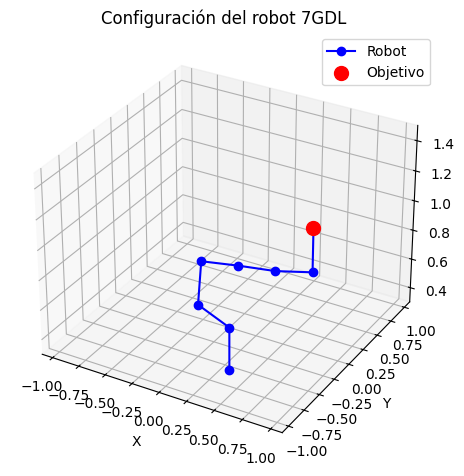

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

# Parámetros DH del robot 7DOF
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

joint_limits = [(-np.pi, np.pi)] * 7
WORKSPACE_X = (-1.1, 1.1)
WORKSPACE_Y = (-1.1, 1.1)
WORKSPACE_Z = (0.3, 1.5)

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    positions = [T[:3, 3]]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        positions.append(T[:3, 3])
    return T[:3, 3], T[:3, :3], T, positions

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def rotation_error(R_current, R_desired):
    R_error = R_desired @ R_current.T
    angle = np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1.0, 1.0))
    if np.isclose(angle, 0):
        return np.zeros(3)
    axis = np.array([
        R_error[2, 1] - R_error[1, 2],
        R_error[0, 2] - R_error[2, 0],
        R_error[1, 0] - R_error[0, 1]
    ])
    if np.linalg.norm(axis) > 1e-10:
        axis = axis / np.linalg.norm(axis)
    return angle * axis

def objective_function_todo(joint_angles, target_pos, target_ori, w=0.5):
    pos, ori, _, _ = forward_kinematics(joint_angles)
    pos_error = np.linalg.norm(target_pos - pos)
    ori_error = np.linalg.norm(rotation_error(ori, target_ori))
    return pos_error + w * ori_error

def inverse_kinematics_slsqp(target_pos, target_ori, w=0.5):
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

    start_time = time.time()
    initial_guess = np.random.uniform(-np.pi/2, np.pi/2, 7)

    result = minimize(
        objective_function_todo,
        initial_guess,
        args=(target_pos, target_ori, w),
        method='SLSQP',
        bounds=joint_limits,
        options={'maxiter': 1000, 'ftol': 1e-4, 'disp': False}
    )

    computation_time = time.time() - start_time

    if result.success:
        print(f"✅ Convergió. Tiempo de cómputo: {computation_time:.4f} segundos")
        return result.x
    else:
        print(f"⚠️ No convergió. Tiempo de cómputo: {computation_time:.4f} segundos")
        return None

def plot_robot(positions, target_position):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs, ys, zs = zip(*positions)
    ax.plot(xs, ys, zs, '-o', color='blue', label='Robot')
    ax.scatter(*target_position, color='red', s=100, label='Objetivo')

    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Configuración del robot 7GDL')
    ax.legend()
    plt.tight_layout()
    plt.show()

# EJEMPLO DE USO
if __name__ == "__main__":
    # Posición y orientación objetivo
    target_position = np.array([0.6, 0.3, 1.0])
    target_orientation = np.eye(3)  # orientación neutra

    solution = inverse_kinematics_slsqp(target_position, target_orientation)

    if solution is not None:
        pos, R, _, positions = forward_kinematics(solution)
        print("🎯 Posición alcanzada:", pos)
        print("🌀 Ángulos articulares:", np.round(solution, 3))
        plot_robot(positions, target_position)


**4. FUNCIÓN CON W Y JACOBIANO CON PSUEDOINVERSA AMORTIGUADA**

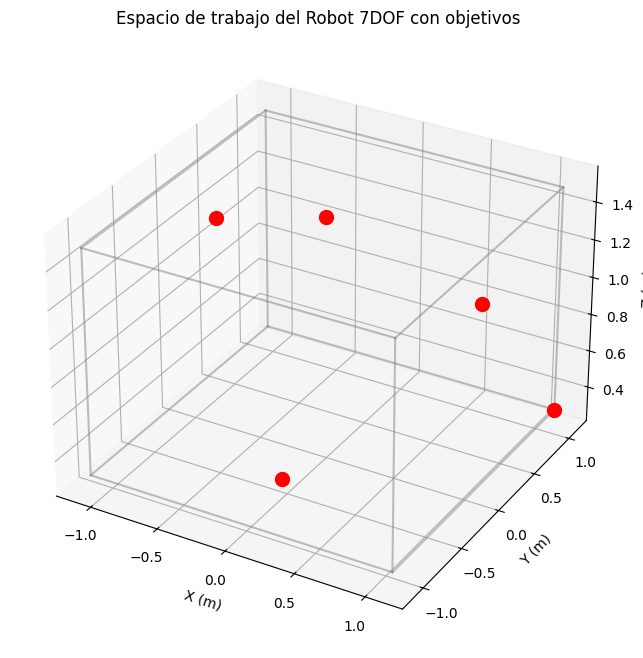


🎯 Objetivo 1: [0.8 0.6 1. ]
⚠️ No convergió después de 1500 iteraciones. Tiempo de cómputo: 3.8270 segundos
Devolviendo la mejor solución encontrada
Tiempo total de cómputo: 3.8272 segundos
✅ Solución encontrada
Ángulos (rad): [ 3.1416  2.5747  1.5245  2.5969 -0.4293 -1.3227  3.1416]
Posición alcanzada: [0.6646 0.4988 0.8782]
Error de posición: 208.37 mm
Error de orientación: 1.8367 rad
Valor de la función objetivo: 1.1267


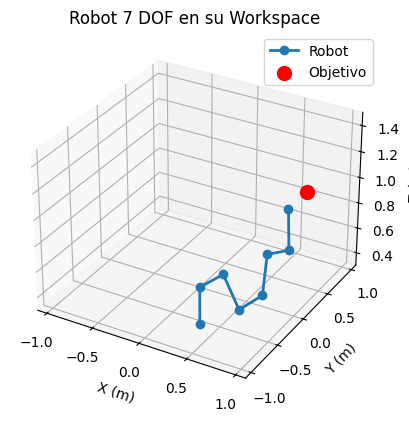


🎯 Objetivo 2: [-1.   0.3  1.2]
⚠️ No convergió después de 1500 iteraciones. Tiempo de cómputo: 2.9878 segundos
Devolviendo la mejor solución encontrada
Tiempo total de cómputo: 2.9880 segundos
✅ Solución encontrada
Ángulos (rad): [-2.7937  0.6324  1.0782 -1.7805  3.1416 -0.3144  3.1416]
Posición alcanzada: [-0.6368  0.4319  1.1424]
Error de posición: 390.70 mm
Error de orientación: 1.2264 rad
Valor de la función objetivo: 1.0039


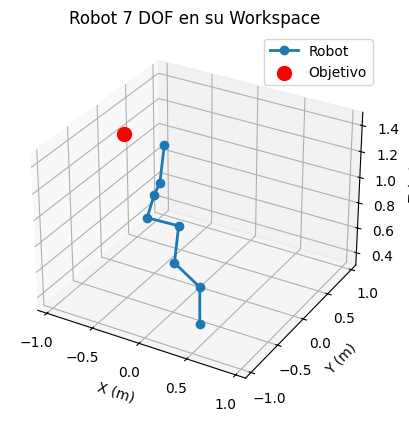


🎯 Objetivo 3: [ 0.2 -0.9  0.5]
Convergió en 14 iteraciones. Tiempo de cómputo: 0.0381 segundos
Tiempo total de cómputo: 0.0382 segundos
✅ Solución encontrada
Ángulos (rad): [-1.3107  1.3113 -0.8242 -1.4939 -1.612   1.0849  1.3975]
Posición alcanzada: [ 0.1998 -0.8998  0.4999]
Error de posición: 0.31 mm
Error de orientación: 0.0007 rad
Valor de la función objetivo: 0.0007


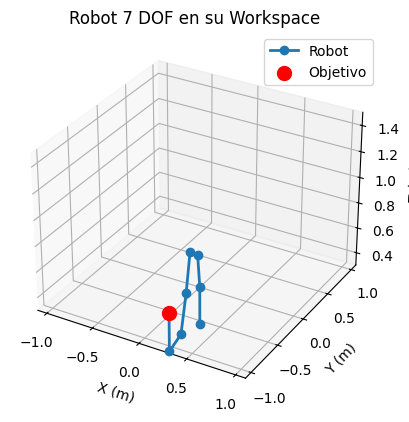


🎯 Objetivo 4: [1.1 1.1 0.3]
⚠️ No convergió después de 1500 iteraciones. Tiempo de cómputo: 3.0312 segundos
Devolviendo la mejor solución encontrada
Tiempo total de cómputo: 3.0314 segundos
✅ Solución encontrada
Ángulos (rad): [ 0.8004 -0.3172  1.1764 -1.4832 -1.5779  0.6537 -0.7464]
Posición alcanzada: [0.8994 0.8704 0.3226]
Error de posición: 305.72 mm
Error de orientación: 0.0864 rad
Valor de la función objetivo: 0.3489


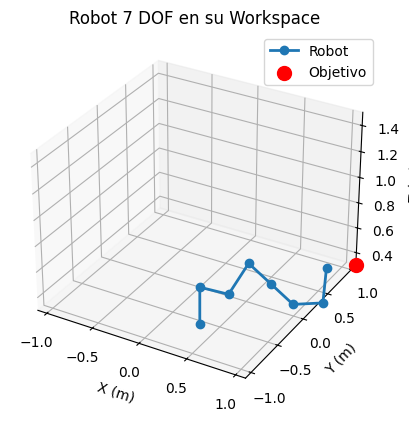


🎯 Objetivo 5: [0.  0.  1.5]
⚠️ No convergió después de 1500 iteraciones. Tiempo de cómputo: 4.2426 segundos
Devolviendo la mejor solución encontrada
Tiempo total de cómputo: 4.2431 segundos
✅ Solución encontrada
Ángulos (rad): [-1.9295 -3.1416 -1.1752  2.8262 -2.7132 -1.7334  3.1416]
Posición alcanzada: [-0.1085  0.2036  1.3156]
Error de posición: 295.37 mm
Error de orientación: 0.5034 rad
Valor de la función objetivo: 0.5471


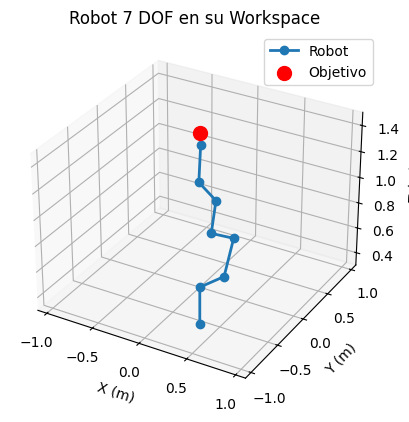

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

# Parámetros DH del robot 7DOF
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Límites articulares
joint_limits = [(-np.pi, np.pi)] * 7

# Límite del espacio de trabajo del artículo (en metros)
WORKSPACE_X = (-1.1, 1.1)
WORKSPACE_Y = (-1.1, 1.1)
WORKSPACE_Z = (0.3, 1.5)

# Puntos deseados dentro del workspace cúbico con orientaciones deseadas (en forma de matrices de rotación)
target_positions = [
    np.array([0.8, 0.6, 1.0]),
    np.array([-1.0, 0.3, 1.2]),
    np.array([0.2, -0.9, 0.5]),
    np.array([1.1, 1.1, 0.3]),
    np.array([0.0, 0.0, 1.5])
]

# Orientaciones deseadas (matrices de rotación 3x3)
# Por simplicidad, usamos matrices de identidad (orientación neutra)
target_orientations = [np.eye(3) for _ in range(len(target_positions))]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T[:3, :3], T  # Posición, Orientación, Matriz completa

def compute_full_jacobian(joint_angles, delta=1e-6):
    """Calcula el Jacobiano completo (posición y orientación)"""
    J_pos = np.zeros((3, 7))
    J_ori = np.zeros((3, 7))

    p0, R0, _ = forward_kinematics(joint_angles)

    for i in range(7):
        dq = np.copy(joint_angles)
        dq[i] += delta
        p1, R1, _ = forward_kinematics(dq)

        # Jacobiano de posición
        J_pos[:, i] = (p1 - p0) / delta

        # Jacobiano de orientación (aproximación por diferencias finitas)
        # Calculamos cambio de orientación usando la representación de ángulo-eje
        dR = R1 @ R0.T - np.eye(3)
        w = np.array([dR[2, 1] - dR[1, 2], dR[0, 2] - dR[2, 0], dR[1, 0] - dR[0, 1]]) / (2 * delta)
        J_ori[:, i] = w

    return J_pos, J_ori

def damped_pseudoinverse(J, damping=1e-2):
    m, n = J.shape
    return J.T @ np.linalg.inv(J @ J.T + damping**2 * np.eye(m))

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def rotation_error(R_current, R_desired):
    """Calcula el error de orientación entre dos matrices de rotación"""
    # Usamos la representación de ángulo-eje
    R_error = R_desired @ R_current.T
    angle = np.arccos((np.trace(R_error) - 1) / 2)
    if np.isclose(angle, 0):
        return np.zeros(3)
    axis = np.array([
        R_error[2, 1] - R_error[1, 2],
        R_error[0, 2] - R_error[2, 0],
        R_error[1, 0] - R_error[0, 1]
    ])
    if np.linalg.norm(axis) > 1e-10:
        axis = axis / np.linalg.norm(axis)
    return angle * axis

def objective_function(pos_current, R_current, pos_desired, R_desired, w=0.5):
    """
    Implementa la función objetivo: min(||Pd - P(θ)|| + w||Rd - R(θ)||)

    Args:
        pos_current: Posición actual del efector final
        R_current: Matriz de rotación actual
        pos_desired: Posición deseada
        R_desired: Matriz de rotación deseada
        w: Factor de peso para el error de orientación

    Returns:
        Valor de la función objetivo
    """
    pos_error = np.linalg.norm(pos_desired - pos_current)
    ori_error = np.linalg.norm(rotation_error(R_current, R_desired))

    return pos_error + w * ori_error

def inverse_kinematics(target_pos, target_ori, initial_guess=None, max_iter=1500, tol=1e-3, w=0.5):
    """
    Cinemática inversa usando la nueva función objetivo

    Args:
        target_pos: Posición objetivo del efector final
        target_ori: Orientación objetivo (matriz de rotación)
        initial_guess: Configuración inicial de ángulos articulares
        max_iter: Número máximo de iteraciones
        tol: Tolerancia para convergencia
        w: Factor de peso para el error de orientación

    Returns:
        Configuración articular solución o None si no converge
    """
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

    # Iniciar con una posición aleatoria si no se proporciona una
    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/2, np.pi/2, 7)

    start_time = time.time()  # Comenzar a medir el tiempo

    best_error = float('inf')
    best_joints = None

    for i in range(max_iter):
        # Calcular posición y orientación actuales
        current_pos, current_ori, _ = forward_kinematics(joint_angles)

        # Calcular errores
        pos_error = target_pos - current_pos
        ori_error = rotation_error(current_ori, target_ori)

        # Evaluar función objetivo
        current_error = objective_function(current_pos, current_ori, target_pos, target_ori, w)

        # Guardar la mejor solución hasta ahora
        if current_error < best_error:
            best_error = current_error
            best_joints = np.copy(joint_angles)

        # Verificar convergencia
        if current_error < tol:
            computation_time = time.time() - start_time
            print(f"Convergió en {i+1} iteraciones. Tiempo de cómputo: {computation_time:.4f} segundos")
            return joint_angles

        # Calcular Jacobianos
        J_pos, J_ori = compute_full_jacobian(joint_angles)

        # Combinar Jacobianos con peso
        J = np.vstack([J_pos, w * J_ori])
        error = np.concatenate([pos_error, w * ori_error])

        # Calcular actualización
        J_pinv = damped_pseudoinverse(J)
        delta_q = J_pinv @ error

        # Actualizar ángulos articulares
        joint_angles += 0.5 * delta_q  # Factor de amortiguamiento para estabilidad

        # Limitar ángulos a sus rangos
        for j in range(7):
            joint_angles[j] = np.clip(joint_angles[j], joint_limits[j][0], joint_limits[j][1])

    computation_time = time.time() - start_time
    print(f"⚠️ No convergió después de {max_iter} iteraciones. Tiempo de cómputo: {computation_time:.4f} segundos")

    # Si no converge, devolver la mejor solución encontrada
    if best_joints is not None:
        print("Devolviendo la mejor solución encontrada")
        return best_joints

    return None

def plot_robot(joint_angles, target=None):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2, label="Robot")
    if target is not None:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Robot 7 DOF en su Workspace")
    ax.legend()
    plt.show()

def plot_workspace_with_targets():
    """Visualiza el espacio de trabajo y los objetivos"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Dibujar los límites del workspace como un cubo
    x_min, x_max = WORKSPACE_X
    y_min, y_max = WORKSPACE_Y
    z_min, z_max = WORKSPACE_Z

    # Crear los vértices del cubo
    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]

    # Aristas del cubo
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Base inferior
        [4, 5], [5, 6], [6, 7], [7, 4],  # Base superior
        [0, 4], [1, 5], [2, 6], [3, 7]   # Conexiones verticales
    ]

    # Dibujar las aristas
    for edge in edges:
        ax.plot3D(
            [vertices[edge[0]][0], vertices[edge[1]][0]],
            [vertices[edge[0]][1], vertices[edge[1]][1]],
            [vertices[edge[0]][2], vertices[edge[1]][2]],
            'gray', alpha=0.5
        )

    # Dibujar los puntos objetivo
    for target in target_positions:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, marker='o')

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Espacio de trabajo del Robot 7DOF con objetivos")
    plt.show()

# Visualizar el espacio de trabajo y los objetivos
plot_workspace_with_targets()

# Peso para el término de orientación en la función objetivo
orientation_weight = 0.5

# Ejecutar cinemática inversa para cada objetivo
for i, target in enumerate(target_positions):
    print(f"\n🎯 Objetivo {i+1}: {target}")
    target_ori = target_orientations[i]

    # Medir tiempo total para esta posición objetivo
    total_start_time = time.time()

    result = inverse_kinematics(target, target_ori, w=orientation_weight)

    total_time = time.time() - total_start_time
    print(f"Tiempo total de cómputo: {total_time:.4f} segundos")

    if result is not None:
        final_pos, final_ori, _ = forward_kinematics(result)
        pos_error = np.linalg.norm(final_pos - target) * 1000  # Error en mm
        ori_error = np.linalg.norm(rotation_error(final_ori, target_ori))

        print("✅ Solución encontrada")
        print(f"Ángulos (rad): {np.round(result, 4)}")
        print(f"Posición alcanzada: {np.round(final_pos, 4)}")
        print(f"Error de posición: {pos_error:.2f} mm")
        print(f"Error de orientación: {ori_error:.4f} rad")

        # Calcular valor de la función objetivo
        obj_value = objective_function(final_pos, final_ori, target, target_ori, orientation_weight)
        print(f"Valor de la función objetivo: {obj_value:.4f}")

        plot_robot(result, target)
    else:
        print("❌ No se encontró solución\n")

FUNCION CON W Y SLSQP


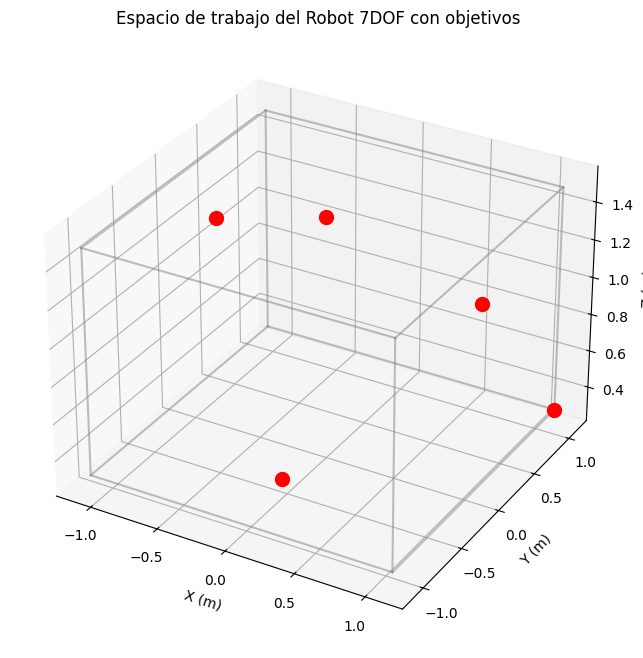


🎯 Objetivo 1: [0.8 0.6 1. ]
Convergió en 27 iteraciones. Tiempo de cómputo: 0.1325 segundos
Tiempo total de cómputo: 0.1326 segundos
✅ Solución encontrada
Ángulos (rad): [-2.0134  2.4721  0.779   3.1416  1.6806  1.5706  0.4422]
Posición alcanzada: [0.5136 0.3832 0.7515]
Error de posición: 436.75 mm
Error de orientación: 0.0005 rad
Valor de la función objetivo: 0.4370


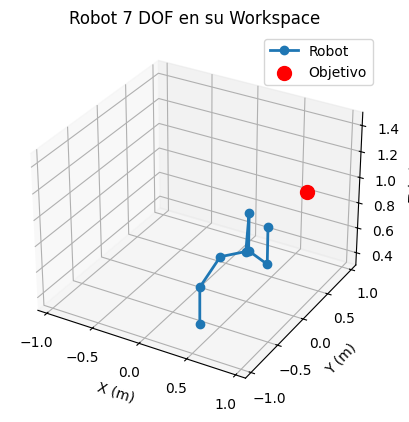


🎯 Objetivo 2: [-1.   0.3  1.2]
Convergió en 26 iteraciones. Tiempo de cómputo: 0.2071 segundos
Tiempo total de cómputo: 0.2075 segundos
✅ Solución encontrada
Ángulos (rad): [-0.5659  0.9385 -3.1416  1.9299 -1.1235 -0.7146  3.1416]
Posición alcanzada: [-0.7308  0.1297  0.974 ]
Error de posición: 390.58 mm
Error de orientación: 0.0002 rad
Valor de la función objetivo: 0.3907


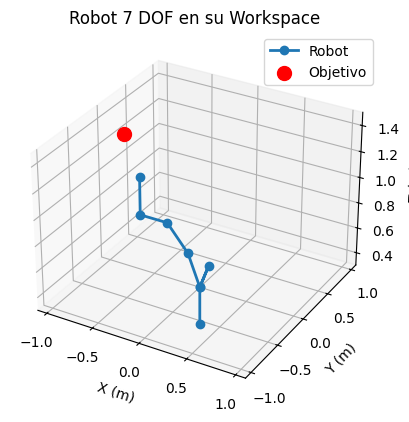


🎯 Objetivo 3: [ 0.2 -0.9  0.5]
Convergió en 38 iteraciones. Tiempo de cómputo: 0.4138 segundos
Tiempo total de cómputo: 0.4248 segundos
✅ Solución encontrada
Ángulos (rad): [ 1.767   3.1416  0.2941 -1.4823  1.5441  1.8637  1.2823]
Posición alcanzada: [ 0.1922 -0.8657  0.513 ]
Error de posición: 37.51 mm
Error de orientación: 0.0001 rad
Valor de la función objetivo: 0.0376


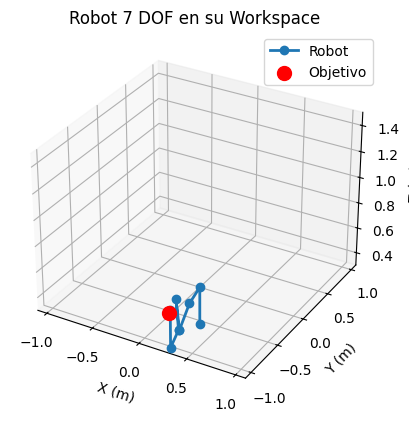


🎯 Objetivo 4: [1.1 1.1 0.3]
Convergió en 20 iteraciones. Tiempo de cómputo: 0.2695 segundos
Tiempo total de cómputo: 0.2698 segundos
✅ Solución encontrada
Ángulos (rad): [ 0.7905 -0.2453  1.1224 -1.5651 -1.5779  0.6924 -0.7816]
Posición alcanzada: [0.879  0.8811 0.3738]
Error de posición: 319.74 mm
Error de orientación: 0.0013 rad
Valor de la función objetivo: 0.3204


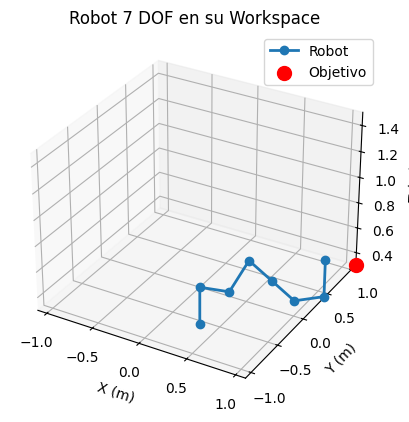


🎯 Objetivo 5: [0.  0.  1.5]
Convergió en 20 iteraciones. Tiempo de cómputo: 0.1961 segundos
Tiempo total de cómputo: 0.1962 segundos
✅ Solución encontrada
Ángulos (rad): [ 0.6695 -0.3075 -3.1416  2.2773 -1.7747 -1.8007  1.7413]
Posición alcanzada: [ 0.0317 -0.1705  1.1786]
Error de posición: 365.20 mm
Error de orientación: 0.0025 rad
Valor de la función objetivo: 0.3664


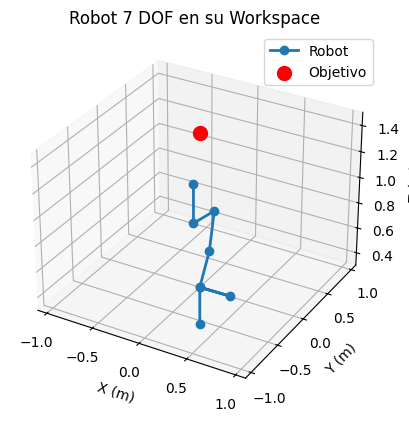

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.optimize import minimize

# Parámetros DH del robot 7DOF
DH_params_7DOF = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Límites articulares
joint_limits = [(-np.pi, np.pi)] * 7

# Límite del espacio de trabajo del artículo (en metros)
WORKSPACE_X = (-1.1, 1.1)
WORKSPACE_Y = (-1.1, 1.1)
WORKSPACE_Z = (0.3, 1.5)

# Puntos deseados dentro del workspace cúbico con orientaciones deseadas (en forma de matrices de rotación)
target_positions = [
    np.array([0.8, 0.6, 1.0]),
    np.array([-1.0, 0.3, 1.2]),
    np.array([0.2, -0.9, 0.5]),
    np.array([1.1, 1.1, 0.3]),
    np.array([0.0, 0.0, 1.5])
]

# Orientaciones deseadas (matrices de rotación 3x3)
# Por simplicidad, usamos matrices de identidad (orientación neutra)
target_orientations = [np.eye(3) for _ in range(len(target_positions))]

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
    return T[:3, 3], T[:3, :3], T  # Posición, Orientación, Matriz completa

def compute_full_jacobian(joint_angles, delta=1e-6):
    """Calcula el Jacobiano completo (posición y orientación)"""
    J_pos = np.zeros((3, 7))
    J_ori = np.zeros((3, 7))

    p0, R0, _ = forward_kinematics(joint_angles)

    for i in range(7):
        dq = np.copy(joint_angles)
        dq[i] += delta
        p1, R1, _ = forward_kinematics(dq)

        # Jacobiano de posición
        J_pos[:, i] = (p1 - p0) / delta

        # Jacobiano de orientación (aproximación por diferencias finitas)
        # Calculamos cambio de orientación usando la representación de ángulo-eje
        dR = R1 @ R0.T - np.eye(3)
        w = np.array([dR[2, 1] - dR[1, 2], dR[0, 2] - dR[2, 0], dR[1, 0] - dR[0, 1]]) / (2 * delta)
        J_ori[:, i] = w

    return J_pos, J_ori

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def rotation_error(R_current, R_desired):
    """Calcula el error de orientación entre dos matrices de rotación"""
    # Usamos la representación de ángulo-eje
    R_error = R_desired @ R_current.T
    angle = np.arccos((np.trace(R_error) - 1) / 2)
    if np.isclose(angle, 0):
        return np.zeros(3)
    axis = np.array([
        R_error[2, 1] - R_error[1, 2],
        R_error[0, 2] - R_error[2, 0],
        R_error[1, 0] - R_error[0, 1]
    ])
    if np.linalg.norm(axis) > 1e-10:
        axis = axis / np.linalg.norm(axis)
    return angle * axis

def objective_function(joint_angles, target_pos, target_ori, w=0.5):
    """
    Implementa la función objetivo para optimización SLSQP: min(||Pd - P(θ)|| + w||Rd - R(θ)||)

    Args:
        joint_angles: Configuración actual de ángulos articulares
        target_pos: Posición deseada
        target_ori: Matriz de rotación deseada
        w: Factor de peso para el error de orientación

    Returns:
        Valor de la función objetivo
    """
    pos_current, R_current, _ = forward_kinematics(joint_angles)

    pos_error = np.linalg.norm(target_pos - pos_current)
    ori_error = np.linalg.norm(rotation_error(R_current, target_ori))

    return pos_error + w * ori_error

def inverse_kinematics_slsqp(target_pos, target_ori, initial_guess=None, w=0.5, max_iter=100, tol=1e-4):
    """
    Cinemática inversa usando el método de optimización SLSQP

    Args:
        target_pos: Posición objetivo del efector final
        target_ori: Orientación objetivo (matriz de rotación)
        initial_guess: Configuración inicial de ángulos articulares
        w: Factor de peso para el error de orientación
        max_iter: Número máximo de iteraciones para SLSQP
        tol: Tolerancia para convergencia

    Returns:
        Configuración articular solución o None si no converge
    """
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None

    # Iniciar con una posición aleatoria si no se proporciona una
    joint_angles = np.copy(initial_guess) if initial_guess is not None else np.random.uniform(-np.pi/2, np.pi/2, 7)

    start_time = time.time()  # Comenzar a medir el tiempo

    # Definir los límites para SLSQP
    bounds = joint_limits

    # Definir función objetivo para SLSQP
    def obj_func(q):
        return objective_function(q, target_pos, target_ori, w)

    # Opciones para SLSQP
    options = {
        'maxiter': max_iter,
        'ftol': tol,
        'disp': False
    }

    # Ejecutar optimización SLSQP
    result = minimize(
        obj_func,
        joint_angles,
        method='SLSQP',
        bounds=bounds,
        options=options
    )

    computation_time = time.time() - start_time

    if result.success:
        print(f"Convergió en {result.nit} iteraciones. Tiempo de cómputo: {computation_time:.4f} segundos")
        return result.x
    else:
        print(f"⚠️ Optimización no exitosa: {result.message}")
        print(f"Tiempo de cómputo: {computation_time:.4f} segundos")

        # Evaluar si la solución es lo suficientemente buena a pesar de no converger
        final_pos, final_ori, _ = forward_kinematics(result.x)
        pos_error = np.linalg.norm(final_pos - target_pos)
        ori_error = np.linalg.norm(rotation_error(final_ori, target_ori))

        if pos_error < 0.01 and ori_error < 0.1:  # Umbral de aceptación pragmático
            print("Aunque no convergió formalmente, la solución es aceptable")
            return result.x

        return None

def plot_robot(joint_angles, target=None):
    T = np.eye(4)
    xs, ys, zs = [0], [0], [0]
    for i in range(7):
        theta = joint_angles[i] + DH_params_7DOF[i][0]
        d, a, alpha = DH_params_7DOF[i][1], DH_params_7DOF[i][2], DH_params_7DOF[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        pos = T[:3, 3]
        xs.append(pos[0])
        ys.append(pos[1])
        zs.append(pos[2])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xs, ys, zs, '-o', linewidth=2, label="Robot")
    if target is not None:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, label='Objetivo')
    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Robot 7 DOF en su Workspace")
    ax.legend()
    plt.show()

def plot_workspace_with_targets():
    """Visualiza el espacio de trabajo y los objetivos"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Dibujar los límites del workspace como un cubo
    x_min, x_max = WORKSPACE_X
    y_min, y_max = WORKSPACE_Y
    z_min, z_max = WORKSPACE_Z

    # Crear los vértices del cubo
    vertices = [
        [x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min],
        [x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]
    ]

    # Aristas del cubo
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Base inferior
        [4, 5], [5, 6], [6, 7], [7, 4],  # Base superior
        [0, 4], [1, 5], [2, 6], [3, 7]   # Conexiones verticales
    ]

    # Dibujar las aristas
    for edge in edges:
        ax.plot3D(
            [vertices[edge[0]][0], vertices[edge[1]][0]],
            [vertices[edge[0]][1], vertices[edge[1]][1]],
            [vertices[edge[0]][2], vertices[edge[1]][2]],
            'gray', alpha=0.5
        )

    # Dibujar los puntos objetivo
    for target in target_positions:
        ax.scatter([target[0]], [target[1]], [target[2]], c='r', s=100, marker='o')

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Espacio de trabajo del Robot 7DOF con objetivos")
    plt.show()

# Visualizar el espacio de trabajo y los objetivos
plot_workspace_with_targets()

# Peso para el término de orientación en la función objetivo
orientation_weight = 0.5

# Ejecutar cinemática inversa para cada objetivo
for i, target in enumerate(target_positions):
    print(f"\n🎯 Objetivo {i+1}: {target}")
    target_ori = target_orientations[i]

    # Medir tiempo total para esta posición objetivo
    total_start_time = time.time()

    # Usar el método SLSQP para la cinemática inversa
    result = inverse_kinematics_slsqp(target, target_ori, w=orientation_weight)

    total_time = time.time() - total_start_time
    print(f"Tiempo total de cómputo: {total_time:.4f} segundos")

    if result is not None:
        final_pos, final_ori, _ = forward_kinematics(result)
        pos_error = np.linalg.norm(final_pos - target) * 1000  # Error en mm
        ori_error = np.linalg.norm(rotation_error(final_ori, target_ori))

        print("✅ Solución encontrada")
        print(f"Ángulos (rad): {np.round(result, 4)}")
        print(f"Posición alcanzada: {np.round(final_pos, 4)}")
        print(f"Error de posición: {pos_error:.2f} mm")
        print(f"Error de orientación: {ori_error:.4f} rad")

        # Calcular valor de la función objetivo
        obj_value = objective_function(result, target, target_ori, orientation_weight)
        print(f"Valor de la función objetivo: {obj_value:.4f}")

        plot_robot(result, target)
    else:
        print("❌ No se encontró solución\n")

FUNCION W CON SLSQP Y DISTINTOS DOF

Ingrese el número de grados de libertad del robot (2 a 7): 7

🤖 Robot 7 DOF | 🎯 Objetivo: [0.6, 0.3, 1.0]
✅ Solución encontrada
📍 Posición alcanzada: [0.5274 0.2636 0.9784]
🌀 Ángulos articulares (°): [  26.56   15.15   74.85   90.     -2.1   180.   -118.66]
📏 Error posición: 0.084062
🔄 Error rotación: 0.000122
⏱️ Tiempo de cómputo: 0.0991 s


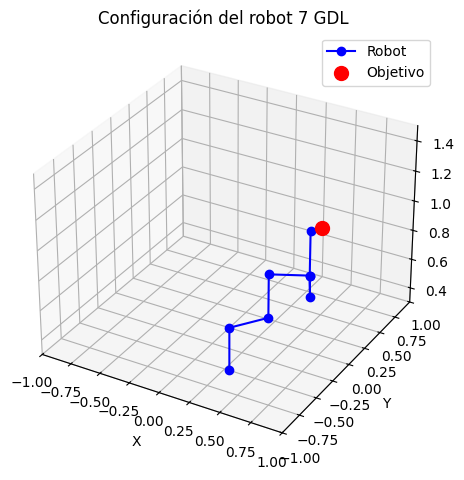

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

# Diccionario de espacios de trabajo por DOF
workspace_dict = {
    2: (-0.4, 0.4, -0.4, 0.4, 0.3, 0.8),
    3: (-0.5, 0.5, -0.5, 0.5, 0.3, 1.0),
    4: (-0.6, 0.6, -0.6, 0.6, 0.3, 1.1),
    5: (-0.7, 0.7, -0.7, 0.7, 0.3, 1.2),
    6: (-0.8, 0.8, -0.8, 0.8, 0.3, 1.3),
    7: (-1.0, 1.0, -1.0, 1.0, 0.3, 1.5)
}

# Plantilla general DH (puedes personalizar según tu robot real)
DH_template = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Preguntar por el número de grados de libertad
DOF = int(input("Ingrese el número de grados de libertad del robot (2 a 7): "))
DH_params = DH_template[:DOF]
joint_limits = [(-np.pi, np.pi)] * DOF

# Espacio de trabajo
ws = workspace_dict[DOF]
WORKSPACE_X, WORKSPACE_Y, WORKSPACE_Z = (ws[0:2], ws[2:4], ws[4:6])

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    positions = [T[:3, 3]]
    for i in range(DOF):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        positions.append(T[:3, 3])
    return T[:3, 3], T[:3, :3], T, positions

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def rotation_error(R_current, R_desired):
    R_error = R_desired @ R_current.T
    angle = np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1.0, 1.0))
    if np.isclose(angle, 0):
        return np.zeros(3)
    axis = np.array([
        R_error[2, 1] - R_error[1, 2],
        R_error[0, 2] - R_error[2, 0],
        R_error[1, 0] - R_error[0, 1]
    ])
    if np.linalg.norm(axis) > 1e-10:
        axis = axis / np.linalg.norm(axis)
    return angle * axis

def objective_function_todo(joint_angles, target_pos, target_ori, w=0.5):
    pos, ori, _, _ = forward_kinematics(joint_angles)
    pos_error = np.linalg.norm(target_pos - pos)
    ori_error = np.linalg.norm(rotation_error(ori, target_ori))
    return pos_error + w * ori_error

def inverse_kinematics_slsqp(target_pos, target_ori, w=0.8):
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None, None

    start_time = time.time()
    initial_guess = np.random.uniform(-np.pi/2, np.pi/2, DOF)

    result = minimize(
        objective_function_todo,
        initial_guess,
        args=(target_pos, target_ori, w),
        method='SLSQP',
        bounds=joint_limits,
        options={'maxiter': 1000, 'ftol': 1e-4, 'disp': False}
    )

    computation_time = time.time() - start_time

    if result.success:
        return result.x, computation_time
    else:
        return None, computation_time

def plot_robot(positions, target_position):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs, ys, zs = zip(*positions)
    ax.plot(xs, ys, zs, '-o', color='blue', label='Robot')
    ax.scatter(*target_position, color='red', s=100, label='Objetivo')

    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Configuración del robot {DOF} GDL')
    ax.legend()
    plt.tight_layout()
    plt.show()

# EJEMPLO DE USO
if __name__ == "__main__":
    target_position = np.array([0.6, 0.3, 1.0])
    target_orientation = np.eye(3)

    print(f"\n🤖 Robot {DOF} DOF | 🎯 Objetivo: {target_position.tolist()}")

    solution, tiempo = inverse_kinematics_slsqp(target_position, target_orientation)

    if solution is not None:
        pos, R, _, positions = forward_kinematics(solution)
        pos_error = np.linalg.norm(pos - target_position)
        rot_error = np.linalg.norm(rotation_error(R, target_orientation))

        print("✅ Solución encontrada")
        print("📍 Posición alcanzada:", np.round(pos, 4))
        print("🌀 Ángulos articulares (°):", np.round(np.degrees(solution), 2))
        print("📏 Error posición:", round(pos_error, 6))
        print("🔄 Error rotación:", round(rot_error, 6))
        print("⏱️ Tiempo de cómputo:", round(tiempo, 4), "s")
        plot_robot(positions, target_position)
    else:
        print("❌ No se encontró una solución")
        print("⏱️ Tiempo de cómputo:", round(tiempo, 4), "s")


FUNCION W CON PSEUDO INVERSA Y METODO JACOBIANO CON DISTINTOS DOF

Ingrese el número de grados de libertad del robot (2 a 7): 7

🤖 Robot 7 DOF | 🎯 Objetivo: [0.6, 0.3, 1.0]
⚠️ No convergió después de 1000 iteraciones
✅ Solución encontrada
📍 Posición alcanzada: [0.4738 0.3283 0.3351]
🌀 Ángulos articulares (°): [ -98.23   44.42 -180.   -180.   -180.     50.97 -166.35]
📏 Error posición: 0.677312
🔄 Error rotación: 2.799162
⏱️ Tiempo de cómputo: 4.6604 s


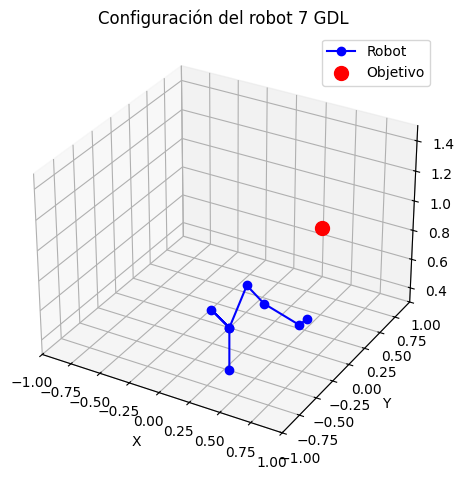

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import time

# Diccionario de espacios de trabajo por DOF
workspace_dict = {
    2: (-0.4, 0.4, -0.4, 0.4, 0.3, 0.8),
    3: (-0.5, 0.5, -0.5, 0.5, 0.3, 1.0),
    4: (-0.6, 0.6, -0.6, 0.6, 0.3, 1.1),
    5: (-0.7, 0.7, -0.7, 0.7, 0.3, 1.2),
    6: (-0.8, 0.8, -0.8, 0.8, 0.3, 1.3),
    7: (-1.0, 1.0, -1.0, 1.0, 0.3, 1.5)
}

# Plantilla general DH (puedes personalizar según tu robot real)
DH_template = [
    [0,  0.3,  0.0,  np.pi/2],
    [0,  0.0,  0.3,  0],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.3,  0.0, -np.pi/2],
    [0,  0.0,  0.3,  np.pi/2],
    [0,  0.0,  0.3, -np.pi/2],
    [0,  0.3,  0.0,  0]
]

# Preguntar por el número de grados de libertad
DOF = int(input("Ingrese el número de grados de libertad del robot (2 a 7): "))
DH_params = DH_template[:DOF]
joint_limits = [(-np.pi, np.pi)] * DOF

# Espacio de trabajo
ws = workspace_dict[DOF]
WORKSPACE_X, WORKSPACE_Y, WORKSPACE_Z = (ws[0:2], ws[2:4], ws[4:6])

def dh_transform(theta, d, a, alpha):
    return np.array([
        [np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
        [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),               d],
        [0,              0,                            0,                           1]
    ])

def forward_kinematics(joint_angles):
    T = np.eye(4)
    positions = [T[:3, 3]]
    for i in range(DOF):
        theta = joint_angles[i] + DH_params[i][0]
        d, a, alpha = DH_params[i][1], DH_params[i][2], DH_params[i][3]
        T = T @ dh_transform(theta, d, a, alpha)
        positions.append(T[:3, 3])
    return T[:3, 3], T[:3, :3], T, positions

def is_within_workspace(target):
    x, y, z = target
    return (WORKSPACE_X[0] <= x <= WORKSPACE_X[1] and
            WORKSPACE_Y[0] <= y <= WORKSPACE_Y[1] and
            WORKSPACE_Z[0] <= z <= WORKSPACE_Z[1])

def rotation_error(R_current, R_desired):
    R_error = R_desired @ R_current.T
    angle = np.arccos(np.clip((np.trace(R_error) - 1) / 2, -1.0, 1.0))
    if np.isclose(angle, 0):
        return np.zeros(3)
    axis = np.array([
        R_error[2, 1] - R_error[1, 2],
        R_error[0, 2] - R_error[2, 0],
        R_error[1, 0] - R_error[0, 1]
    ])
    if np.linalg.norm(axis) > 1e-10:
        axis = axis / np.linalg.norm(axis)
    return angle * axis

def calculate_jacobian(joint_angles):
    """Calcula el Jacobiano del robot en la configuración actual."""
    delta = 1e-6
    pos, ori, _, _ = forward_kinematics(joint_angles)

    # Calculamos el jacobiano para la posición (3 filas) y orientación (3 filas)
    J = np.zeros((6, DOF))

    for i in range(DOF):
        # Copiamos los ángulos y perturbamos el ángulo i
        q_delta = joint_angles.copy()
        q_delta[i] += delta

        pos_delta, ori_delta, _, _ = forward_kinematics(q_delta)

        # Diferencia de posición
        J[0:3, i] = (pos_delta - pos) / delta

        # Diferencia de orientación (usando el error de rotación)
        rot_err = rotation_error(ori, ori_delta) / delta
        J[3:6, i] = -rot_err  # Invertimos el signo para mantener consistencia

    return J

def damped_pseudo_inverse(J, lambda_damp=0.1):
    """Calcula la pseudoinversa amortiguada del Jacobiano."""
    m, n = J.shape
    if m >= n:  # Si hay más ecuaciones que incógnitas
        return np.linalg.inv(J.T @ J + lambda_damp**2 * np.eye(n)) @ J.T
    else:  # Si hay más incógnitas que ecuaciones
        return J.T @ np.linalg.inv(J @ J.T + lambda_damp**2 * np.eye(m))

def objective_function_todo(joint_angles, target_pos, target_ori, w=0.5):
    pos, ori, _, _ = forward_kinematics(joint_angles)
    pos_error = np.linalg.norm(target_pos - pos)
    ori_error = np.linalg.norm(rotation_error(ori, target_ori))
    return pos_error + w * ori_error

def inverse_kinematics_damped_pinv(target_pos, target_ori, max_iter=1000, tol=1e-4, lambda_damp=0.1, w=0.8):
    """Resuelve cinemática inversa usando Jacobiano con pseudoinversa amortiguada."""
    if not is_within_workspace(target_pos):
        print(f"⚠️ Objetivo fuera del espacio de trabajo: {target_pos}")
        return None, None

    start_time = time.time()
    # Inicialización aleatoria
    q = np.random.uniform(-np.pi/2, np.pi/2, DOF)

    # Bucle principal
    for i in range(max_iter):
        pos, ori, _, _ = forward_kinematics(q)

        # Error de posición
        e_pos = target_pos - pos

        # Error de orientación
        e_rot = rotation_error(ori, target_ori)

        # Vector de error completo (ponderado según el factor w)
        error = np.concatenate([e_pos, w * e_rot])

        # Calculamos el valor de la función objetivo para verificar convergencia
        obj_value = objective_function_todo(q, target_pos, target_ori, w)
        if obj_value < tol:
            computation_time = time.time() - start_time
            return q, computation_time

        # Calculamos Jacobiano
        J = calculate_jacobian(q)

        # Pseudoinversa amortiguada
        J_pinv = damped_pseudo_inverse(J, lambda_damp)

        # Actualización del vector de configuración
        delta_q = J_pinv @ error

        # Limitamos el paso máximo
        alpha = min(1.0, 0.5 / (np.linalg.norm(delta_q) + 1e-10))
        q = q + alpha * delta_q

        # Aplicamos límites de articulaciones
        for j in range(DOF):
            q[j] = np.clip(q[j], joint_limits[j][0], joint_limits[j][1])

    # Si llegamos aquí, no ha convergido
    computation_time = time.time() - start_time
    print(f"⚠️ No convergió después de {max_iter} iteraciones")
    return q, computation_time

def plot_robot(positions, target_position):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs, ys, zs = zip(*positions)
    ax.plot(xs, ys, zs, '-o', color='blue', label='Robot')
    ax.scatter(*target_position, color='red', s=100, label='Objetivo')

    ax.set_xlim(WORKSPACE_X)
    ax.set_ylim(WORKSPACE_Y)
    ax.set_zlim(WORKSPACE_Z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Configuración del robot {DOF} GDL')
    ax.legend()
    plt.tight_layout()
    plt.show()

# EJEMPLO DE USO
if __name__ == "__main__":
    target_position = np.array([0.6, 0.3, 1.0])
    target_orientation = np.eye(3)

    print(f"\n🤖 Robot {DOF} DOF | 🎯 Objetivo: {target_position.tolist()}")

    solution, tiempo = inverse_kinematics_damped_pinv(target_position, target_orientation)

    if solution is not None:
        pos, R, _, positions = forward_kinematics(solution)
        pos_error = np.linalg.norm(pos - target_position)
        rot_error = np.linalg.norm(rotation_error(R, target_orientation))

        print("✅ Solución encontrada")
        print("📍 Posición alcanzada:", np.round(pos, 4))
        print("🌀 Ángulos articulares (°):", np.round(np.degrees(solution), 2))
        print("📏 Error posición:", round(pos_error, 6))
        print("🔄 Error rotación:", round(rot_error, 6))
        print("⏱️ Tiempo de cómputo:", round(tiempo, 4), "s")
        plot_robot(positions, target_position)
    else:
        print("❌ No se encontró una solución")
        print("⏱️ Tiempo de cómputo:", round(tiempo, 4), "s")